In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os, sys
import random, math
from datetime import datetime
from copy import deepcopy
from collections import defaultdict
from itertools import product

import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
from tqdm.notebook import tqdm_notebook as tqdm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

/home/kovalexal/.conda/envs/ml/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
env = gym.make('Blackjack-v0', natural=True)
env.reset()

print(f'Action space: {env.action_space}')
print(f'Observation space: {env.observation_space}')
print()

observation, reward, done, info = env.step(env.action_space.sample())

# The observation of a 3-tuple of: the players current sum,
# the dealer's one showing card (1-10 where 1 is ace),
# and whether or not the player holds a usable ace (0 or 1).
print(f'Observation: {observation}')


print(f'Reward: {reward}')
print(f'done: {done}')
print(f'info: {info}')

Action space: Discrete(2)
Observation space: Tuple(Discrete(32), Discrete(11), Discrete(2))

Observation: (18, 10, False)
Reward: 0.0
done: False
info: {}


In [5]:
env.reset()

(14, 5, False)

In [6]:
env.step(0)

((14, 5, False), 1.0, True, {})

In [7]:
env.step(1)

((24, 5, False), -1.0, True, {})

In [8]:
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

In [9]:
env._get_obs()

(24, 5, False)

# Advanced DL and RL: Домашнее задание 1

Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое, чтобы можно было обучить хорошую стратегию методами TD-обучения или другими методами обучения с подкреплением. Задание получилось, надеюсь, интересное, но в том числе и достаточно техническое, так что для решения придётся немножко попрограммировать. Поэтому в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

## Часть первая, с блекджеком и стратегиями

Мы будем обучаться играть в очень простую, но всё-таки знаменитую и популярную игру: блекджек. Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
- численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
- туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
- игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
- игрок может совершать одно из двух действий:
    - hit  — взять ещё одну карту;
    - stand — не брать больше карт;
- если сумма очков у игрока на руках больше 21, он проигрывает (bust);
- если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
- после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
- в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).

Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/38a1f630dc9815a567aaf299ae5844c8f8b9a6fa/gym/envs/toy_text/blackjack.py

### 1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [10]:
def valueof(x):
    return 0.0 if np.isneginf(x) else x

In [11]:
def maxof(x):
    m = np.max(x)
    return 0.0 if np.isneginf(m) else m

Опишем стратегию, которая случайным образом выбирает действие

In [12]:
def policy_random():
    def strategy(env):
        return env.action_space.sample()
    return strategy

Опишем простую стратегию, при которой мы берем карту только, если сумма у нас на руках $< 19$

In [13]:
def policy_simple(threshold=19):
    def strategy(env):
        return int(env._get_obs()[0] < threshold)
    return strategy

Опишем функцию, которая вернет нам следующее **жадное** действие в состоянии $state$ при политике $Q$

In [14]:
def action_q(state, Q):
    return np.argmax(Q[state])

Опишем стратегию, которая действует по обученной политике $Q$

In [15]:
def policy_q(Q, eps=0.0):
    def strategy(env):
        state = env._get_obs()
        if (random.random() <= eps) or (state not in Q):
        #if (random.random() <= eps):
            return env.action_space.sample()
        return action_q(state, Q)
    return strategy

Опишем функцию игры в блекджек, которая будет возвращать нам результат одной игры

In [16]:
def blackjack_episode(policy, env=gym.make('Blackjack-v0', natural=True), random_state=None, verbose=False):
    states, actions, rewards = [], [], []
    
    if random_state:
        random.seed(random_state)
        env.seed(random_state)
        env.action_space.seed(random_state)
    initial_state = env.reset()

    if verbose:
        print(f'Стартовая раздача: {initial_state}')

    while True:
        states.append(env._get_obs())

        # Выбираем следующее действие
        action = policy(env)
        actions.append(action)
        if verbose:
            if action == 0:
                print('Не берем карту')
            elif action == 1:
                print('Берем карту')
            elif action == 2:
                print('Удваиваем')
            elif action == 3:
                print('Делаем split')

        # Совершаем следующее действие
        state, reward, done, _ = env.step(action)
        if verbose:
            print(f'Текущая раздача: {state}, текущая награда: {reward}')

        # Запоминаем полученную награду
        rewards.append(reward)

        # Если эпизод закончился, выходим
        if done:
            env.close()
            break
            
    return states, actions, rewards

blackjack_episode(policy_random(), random_state=6, verbose=True)

Стартовая раздача: (8, 2, False)
Берем карту
Текущая раздача: (19, 2, True), текущая награда: 0.0
Берем карту
Текущая раздача: (19, 2, False), текущая награда: 0.0
Не берем карту
Текущая раздача: (19, 2, False), текущая награда: 1.0


([(8, 2, False), (19, 2, True), (19, 2, False)], [1, 1, 0], [0.0, 0.0, 1.0])

Расчет метода Монте-Карло можно осуществлять в двух вариантах - First-Visit и Every-Visit.

Разница между ними неплохо объяснена [здесь](https://ai.stackexchange.com/a/10818)

![](https://i.stack.imgur.com/Q8YCg.png)

Опишем метод монте-карло для расчета $V_{\pi}(s)$, так, чтобы он поддерживал эти два режима работы

In [17]:
def monte_carlo_estimation(policy, estimation_type='first', env=gym.make('Blackjack-v0', natural=True), random_state=None, num_experiments=10000, gamma=1.0):
    V, N = defaultdict(float), defaultdict(int)
    
    # Фиксируем seed
    random.seed(random_state)
    env.seed(random_state)
    env.action_space.seed(random_state)
    
    # Определим запрошенный тип (first или every)
    if estimation_type not in ['first', 'every']:
        raise NotImplementedError(f'Estimation type {estimation_type} is not implemented')
    is_estimation_type_first = estimation_type == 'first'
    
    for _ in range(num_experiments):
        # Порождаем эпизод
        states, actions, rewards = blackjack_episode(policy, env)
        G = 0.0
        
        # Идем по эпизоду в обратном порядке
        for t in range(len(states) - 1, -1, -1):
            G = gamma * G + rewards[t]
            S = states[t]
            
            # Будем производить обновление только в случае, когда это нужно
            needs_update = False
            if (is_estimation_type_first) and not(S in states[:t]):
                needs_update = True
            else:
                needs_update = True
            
            # Обновляем только нужные посещения этого состояния
            if needs_update:
                V[S] += G
                N[S] += 1
                
    env.close()
            
    # Нормируем результат
    for S, G in V.items():
        V[S] /= N[S]
        
    # Возвращаем результат
    return V

Опишем расчет средней награды от игры с использованием имеющейся функции политики

In [18]:
def calculate_reward_by_policy(policy, env=gym.make('Blackjack-v0', natural=True), num_experiments=100000, random_state=None):
    # Фиксируем seed
    random.seed(random_state)
    env.seed(random_state)
    env.action_space.seed(random_state)
    
    # Будем считать общий ревард по полученной функции V(S), получая первичное S случайной инициализацией состояния среды
    s_reward = 0.0
    for _ in range(num_experiments):
        states, actions, rewards = blackjack_episode(policy, env)
        s_reward += rewards[-1]
        
    return s_reward / num_experiments

$V_{random}(S) = V_{\pi_{random}}(S)$, где $\pi_{random}$ - случайная стратегия

In [19]:
%%time
V_random = monte_carlo_estimation(policy_random(), estimation_type='first', num_experiments=100000, random_state=42, gamma=1.0)

CPU times: user 3.13 s, sys: 3.68 ms, total: 3.14 s
Wall time: 3.15 s


In [20]:
dict(random.sample(V_random.items(), 5))

{(13, 1, True): -0.6219512195121951,
 (15, 3, False): -0.5246575342465754,
 (15, 3, True): -0.11320754716981132,
 (12, 5, False): -0.38773148148148145,
 (21, 5, False): -0.08719346049046321}

Средняя награда по политике $\pi_{random}$

In [21]:
calculate_reward_by_policy(policy_random(), num_experiments=100000, random_state=42)

-0.38696

$V_{simple}(S) = V_{\pi_{simple}}(S)$, где $\pi_{simple}$ - простая стратегия, когда мы берем карту, если на руках $< 19$

In [22]:
%%time
V_simple = monte_carlo_estimation(policy_simple(), estimation_type='first', num_experiments=100000, random_state=42, gamma=1.0)

CPU times: user 3.14 s, sys: 3.26 ms, total: 3.14 s
Wall time: 3.14 s


In [23]:
dict(random.sample(V_simple.items(), 5))

{(20, 8, False): 0.7929078014184398,
 (13, 10, False): -0.502021018593371,
 (15, 1, False): -0.6780684104627767,
 (11, 6, False): 0.07221006564551423,
 (15, 5, False): -0.5115810674723061}

Средняя награда по политике $\pi_{simple}$

In [24]:
calculate_reward_by_policy(policy_simple(), num_experiments=100000, random_state=42)

-0.18129

Видно, что с данными стратегиями особо не разгуляешься, хотя наша стратегия и лучше случайной игры

### 2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

Реализуем стратегию уменьшения $\epsilon$ для постепенного ужесточения стратегий

In [19]:
def eps_decay(eps_start=1.0, eps_min=0.01, decay=0.99999):
    epsilon = eps_start
    yield epsilon
    while True:
        epsilon = max(eps_min, epsilon * decay)
        yield epsilon

Реализуем константную стратегию работы с $\epsilon$ для того, чтобы наша стратегия оставалась $\epsilon$-мягкой

In [20]:
def eps_constant(epsilon=1.0):
    while True:
        yield epsilon

Попробуем On-Policy Monte-Carlo Control

![](https://i.stack.imgur.com/033M8.png)

In [21]:
def monte_carlo_control_on_policy(eps_generator, env=gym.make('Blackjack-v0', natural=True), num_experiments=10000, random_state=None, gamma=1.0, score_every=0.1, score_func=None, verbose=False):
    space_n = env.action_space.n
    Q = defaultdict(lambda: np.full(space_n, -np.inf))
    N = defaultdict(int)
    scores = []
    
    # Фиксируем seed
    random.seed(random_state)
    env.seed(random_state)
    env.action_space.seed(random_state)
    
    # Основная итерация
    for i in range(num_experiments):
        # Получаем текущий eps
        eps = next(eps_generator)
        
        # Берем имеющуюся политику на текущем шаге
        policy = policy_q(Q, eps)
        
        # Порождаем эпизод
        states, actions, rewards = blackjack_episode(policy, env=env)
        states_actions = list(zip(states, actions))
        
        # Инициализация
        G = 0.0
        
        # Идем по эпизоду в обратном порядке
        for t in range(len(states_actions) - 1, -1, -1):
            G = gamma * G + rewards[t]
            S, A = states[t], actions[t]
            SA = states_actions[t]
            
            # Будем производить обновление только в первый раз, когда мы находились в этом состоянии и сделали это действие
            if not(SA in states_actions[:t]):
                N[SA] += 1
                v = valueof(Q[S][A])
                Q[S][A] = v + (G - v) / N[SA]
                
        # Осуществим скоринг текущего решения
        if ((i + 1) % int(num_experiments * score_every)) == 0:
            if not (score_func is None):
                random_state = random.getstate()
                scores.append({
                    'gamma': gamma,
                    'epsilon': eps,
                    'experiment': i + 1,
                    'score': score_func(policy_q(deepcopy(Q), 0.0), env=env)
                })
                if verbose:
                    print(f'Score at {i + 1} / {num_experiments} = {scores[-1]["score"]}')
                random.setstate(random_state)
                
    env.close()
    
    return Q, scores

Рассчитаем $Q_{*}(S, A)$, где данная стратегия получится лучшей $\epsilon$-мягкой

In [28]:
%%time
Q_star_mc_on, _ = monte_carlo_control_on_policy(eps_decay(), num_experiments=1000000, random_state=42, gamma=1.0)

CPU times: user 55.4 s, sys: 1.17 s, total: 56.6 s
Wall time: 55.1 s


In [29]:
dict(random.sample(Q_star_mc_on.items(), 5))

{(5, 5, False): array([-0.42105263, -0.09473684]),
 (9, 7, False): array([-0.52317881,  0.11424685]),
 (20, 9, False): array([ 0.75502972, -0.87204724]),
 (19, 8, True): array([ 0.57710761, -0.05263158]),
 (19, 3, True): array([0.42459736, 0.07142857])}

In [30]:
calculate_reward_by_policy(policy_q(Q_star_mc_on, 0.0), num_experiments=1000000, random_state=42)

-0.043085

Уже лучше, но давайте попробуем Off-Policy обучение

![](https://i.stack.imgur.com/Xi0vX.png)

In [22]:
def monte_carlo_control_off_policy(eps_generator, env=gym.make('Blackjack-v0', natural=True), num_experiments=10000, random_state=None, gamma=1.0, score_every=0.1, score_func=None, verbose=False):
    space_n = env.action_space.n
    Q = defaultdict(lambda: np.full(space_n, -np.inf))
    C = defaultdict(lambda: np.zeros(space_n))
    scores = []
    
    # Фиксируем seed
    random.seed(random_state)
    env.seed(random_state)
    env.action_space.seed(random_state)
    
    # Основная итерация
    for i in range(num_experiments):
        # Получаем текущий eps
        eps = next(eps_generator)
        
        # Задаем поведенческую стратегию
        behavioral = policy_q(Q, eps)
        
        # Порождаем эпизод по этой поведенческой стратегии
        b_states, b_actions, b_rewards = blackjack_episode(behavioral, env)
        
        # Начальная инициализация
        G, rho = 0.0, 1.0
        
        # Идем по эпизоду в обратном порядке с предпоследнего действия
        for t in range(len(b_states) - 1, -1, -1):
            S, A, R = b_states[t], b_actions[t], b_rewards[t]
            discount = 1 - (env.action_space.n-1) * eps / env.action_space.n
            
            # Обновляем дисконтированную награду
            G = gamma * G + R
            
            # Обновляем Q и C
            C[S][A] += rho
            v = valueof(Q[S][A])
            Q[S][A] = v + (rho / C[S][A]) * (G - v)
            
            # Если действие на текущем шаге не соответствует жесткой стратегии, пропускаем весь эпизод
            if (A != action_q(S, Q)):
                break
                
            rho = rho / discount
            
        # Осуществим скоринг текущего решения
        if ((i + 1) % int(num_experiments * score_every)) == 0:
            if not (score_func is None):
                random_state = random.getstate()
                scores.append({
                    'gamma': gamma,
                    'epsilon': eps,
                    'experiment': i + 1,
                    'score': score_func(policy_q(deepcopy(Q), 0.0), env=env)
                })
                if verbose:
                    print(f'Score at {i + 1} / {num_experiments} = {scores[-1]["score"]}')
                random.setstate(random_state)
    
    env.close()
    
    return Q, scores

In [32]:
%%time
Q_star_mc_off, _ = monte_carlo_control_off_policy(eps_constant(0.5), num_experiments=1000000, random_state=42, gamma=1.0)

CPU times: user 56.1 s, sys: 677 ms, total: 56.8 s
Wall time: 55.9 s


In [33]:
dict(random.sample(Q_star_mc_off.items(), 5))

{(8, 6, False): array([-0.11437908,  0.10707635]),
 (17, 7, False): array([-0.10593925, -0.48096162]),
 (18, 9, True): array([-0.09906542, -0.10681334]),
 (20, 9, False): array([ 0.75147723, -0.84749913]),
 (14, 10, False): array([-0.5641784 , -0.49433809])}

In [34]:
calculate_reward_by_policy(policy_q(Q_star_mc_off, 0.0), num_experiments=100000, random_state=42)

-0.02418

Уже лучше, реализуем SARSA/TD-0 для эпизодической задачи

![](https://miro.medium.com/max/700/1*fYuXsaJoyCWuIZu49vx_GA.png)

In [23]:
def sarsa(eps_generator, env=gym.make('Blackjack-v0', natural=True), num_experiments=10000, random_state=None, gamma=1.0, alpha=0.01, score_every=0.1, score_func=None, verbose=False):
#     Q = defaultdict(lambda: np.zeros(env.action_space.n))
    space_n = env.action_space.n
    Q = defaultdict(lambda: np.full(space_n, -np.inf))
    scores = []
    
    # Фиксируем seed
    random.seed(random_state)
    env.seed(random_state)
    env.action_space.seed(random_state)
    
    # Основная итерация
    for i in range(num_experiments):
        # Получаем текущий eps
        eps = next(eps_generator)
        
        # Задаем поведенческую стратегию
        policy = policy_q(Q, eps)
        
        # Порождаем эпизод по этой стратегии
        states, actions, rewards = blackjack_episode(policy, env)
        
        # Обрабатываем последний опыт
        v = valueof(Q[states[-1]][actions[-1]])
        Q[states[-1]][actions[-1]] = v + alpha * (rewards[-1] - gamma * v)
        
        # Итерируемся по опыту
        for Sc, Ac, Rc, Sn, An in zip(states[-2::-1], actions[-2::-1], rewards[-2::-1], states[::-1], actions[::-1]):
            v1 = valueof(Q[Sn][An])
            v2 = valueof(Q[Sc][Ac])
            Q[Sc][Ac] = v2 + alpha * (Rc + gamma * v1 - v2)
            
        # Осуществим скоринг текущего решения
        if ((i + 1) % int(num_experiments * score_every)) == 0:
            if not (score_func is None):
                random_state = random.getstate()
                scores.append({
                    'gamma': gamma,
                    'epsilon': eps,
                    'experiment': i + 1,
                    'score': score_func(policy_q(deepcopy(Q), 0.0), env=env)
                })
                if verbose:
                    print(f'Score at {i + 1} / {num_experiments} = {scores[-1]["score"]}')
                random.setstate(random_state)
            
    return Q, scores

In [36]:
%%time
Q_star_sarsa, _ = sarsa(eps_decay(), num_experiments=1000000, random_state=42, gamma=1.0, alpha=0.01)

CPU times: user 55.9 s, sys: 944 ms, total: 56.9 s
Wall time: 55.6 s


In [37]:
dict(random.sample(Q_star_sarsa.items(), 5))

{(4, 3, False): array([-0.12385751, -0.07559513]),
 (20, 8, False): array([ 0.76167212, -0.88434992]),
 (7, 4, False): array([-0.09080446, -0.05146196]),
 (16, 4, True): array([-0.14297076,  0.10388813]),
 (11, 10, False): array([-0.56546318,  0.08202591])}

In [38]:
calculate_reward_by_policy(policy_q(Q_star_sarsa, 0.0), num_experiments=100000, random_state=42)

-0.02818

Реализуем Q-learning для эпизодической задачи

![](https://miro.medium.com/max/700/1*Rf_H0YXhSPPm-iyBY2Gnjg.png)

In [24]:
def q_learning(eps_generator, env=gym.make('Blackjack-v0', natural=True), num_experiments=10000, random_state=None, gamma=1.0, alpha=0.01, score_every=0.1, score_func=None, verbose=False):
#     Q = defaultdict(lambda: np.zeros(env.action_space.n))
    #Q = defaultdict(lambda: np.full(env.action_space.n, -np.inf))
    space_n = env.action_space.n
    Q = defaultdict(lambda: np.full(space_n, -np.inf))
    scores = []
    
    # Фиксируем seed
    random.seed(random_state)
    env.seed(random_state)
    env.action_space.seed(random_state)
    
    # Основная итерация
    for i in range(num_experiments):
        # Получаем текущий eps
        eps = next(eps_generator)
        
        # Задаем поведенческую стратегию
        policy = policy_q(Q, eps)
        
        # Порождаем эпизод по этой поведенческой стратегии
        states, actions, rewards = blackjack_episode(policy, env)
        
        # Обрабатываем последний опыт
        v = valueof(Q[states[-1]][actions[-1]])
        Q[states[-1]][actions[-1]] = v + alpha * (rewards[-1] - gamma * maxof(Q[states[-1]]))
        
        # Итерируемся по опыту
        for Sc, Ac, Rc, Sn, An in zip(states[-2::-1], actions[-2::-1], rewards[-2::-1], states[::-1], actions[::-1]):
            v = valueof(Q[Sc][Ac])
            Q[Sc][Ac] = v + alpha * (Rc + gamma * maxof(Q[Sn]) - v)
            
        # Осуществим скоринг текущего решения
        if ((i + 1) % int(num_experiments * score_every)) == 0:
            if not (score_func is None):
                random_state = random.getstate()
                scores.append({
                    'gamma': gamma,
                    'epsilon': eps,
                    'experiment': i + 1,
                    'score': score_func(policy_q(deepcopy(Q), 0.0), env=env)
                })
                if verbose:
                    print(f'Score at {i + 1} / {num_experiments} = {scores[-1]["score"]}')
                random.setstate(random_state)
            
    return Q, scores

In [40]:
%%time
Q_star_qlearning, _ = q_learning(eps_constant(0.5), num_experiments=1000000, random_state=42, gamma=1.0, alpha=0.01)

CPU times: user 1min 8s, sys: 684 ms, total: 1min 9s
Wall time: 1min 8s


In [41]:
dict(random.sample(Q_star_qlearning.items(), 5))

{(18, 2, False): array([ 0.17744285, -3.12612541]),
 (19, 10, False): array([-0.09370888, -4.61536894]),
 (5, 5, False): array([-0.2671037, -0.0458607]),
 (21, 1, True): array([ 0.77784636, -0.06513373]),
 (13, 4, False): array([-0.17949659, -0.31094118])}

In [42]:
calculate_reward_by_policy(policy_q(Q_star_qlearning, 0.0), num_experiments=100000, random_state=42)

-0.03072

### 3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [25]:
def plot_learning_curve(algorithms, env, title='', num_experiments=100000, score_func=calculate_reward_by_policy, score_every=0.1, random_state=42):
    for a in algorithms:
        print(f'{datetime.now()} - Learning {a}')
        params = {}
        params.update(a['eps_params'])
        params.update(a['method_params'])
        eps_generator = a['eps'](**a['eps_params'])

        # Обучаем алгоритм
        Q, scores = a['method'](eps_generator, env=env, num_experiments=num_experiments, random_state=random_state, score_every=score_every, score_func=score_func, **a['method_params'])

        # Формируем строку с параметрами для легенды
        params_str = ', '.join([r'$\{} = {}$'.format(k, np.round(v, 2)) for (k, v) in params.items()])

        # Рисуем график для текущего алгоритма
        plt.plot(
            [x['experiment'] for x in scores],
            [x['score'] for x in scores],
            label=f"{a['name']} {params_str}"
        )
    plt.legend()
    plt.title(title)
    plt.show()

Попробуем подобрать параметры для On-Policy Monte Carlo Control

2020-11-07 15:24:38.065387 - Learning {'name': '', 'method': <function monte_carlo_control_on_policy at 0x7fe216df6320>, 'method_params': {'gamma': 0.0}, 'eps': <function eps_decay at 0x7fe21d3294d0>, 'eps_params': {}}
2020-11-07 15:25:57.213377 - Learning {'name': '', 'method': <function monte_carlo_control_on_policy at 0x7fe216df6320>, 'method_params': {'gamma': 0.1}, 'eps': <function eps_decay at 0x7fe21d3294d0>, 'eps_params': {}}
2020-11-07 15:27:17.714431 - Learning {'name': '', 'method': <function monte_carlo_control_on_policy at 0x7fe216df6320>, 'method_params': {'gamma': 0.2}, 'eps': <function eps_decay at 0x7fe21d3294d0>, 'eps_params': {}}
2020-11-07 15:28:37.366238 - Learning {'name': '', 'method': <function monte_carlo_control_on_policy at 0x7fe216df6320>, 'method_params': {'gamma': 0.30000000000000004}, 'eps': <function eps_decay at 0x7fe21d3294d0>, 'eps_params': {}}
2020-11-07 15:29:56.837672 - Learning {'name': '', 'method': <function monte_carlo_control_on_policy at 0x7f

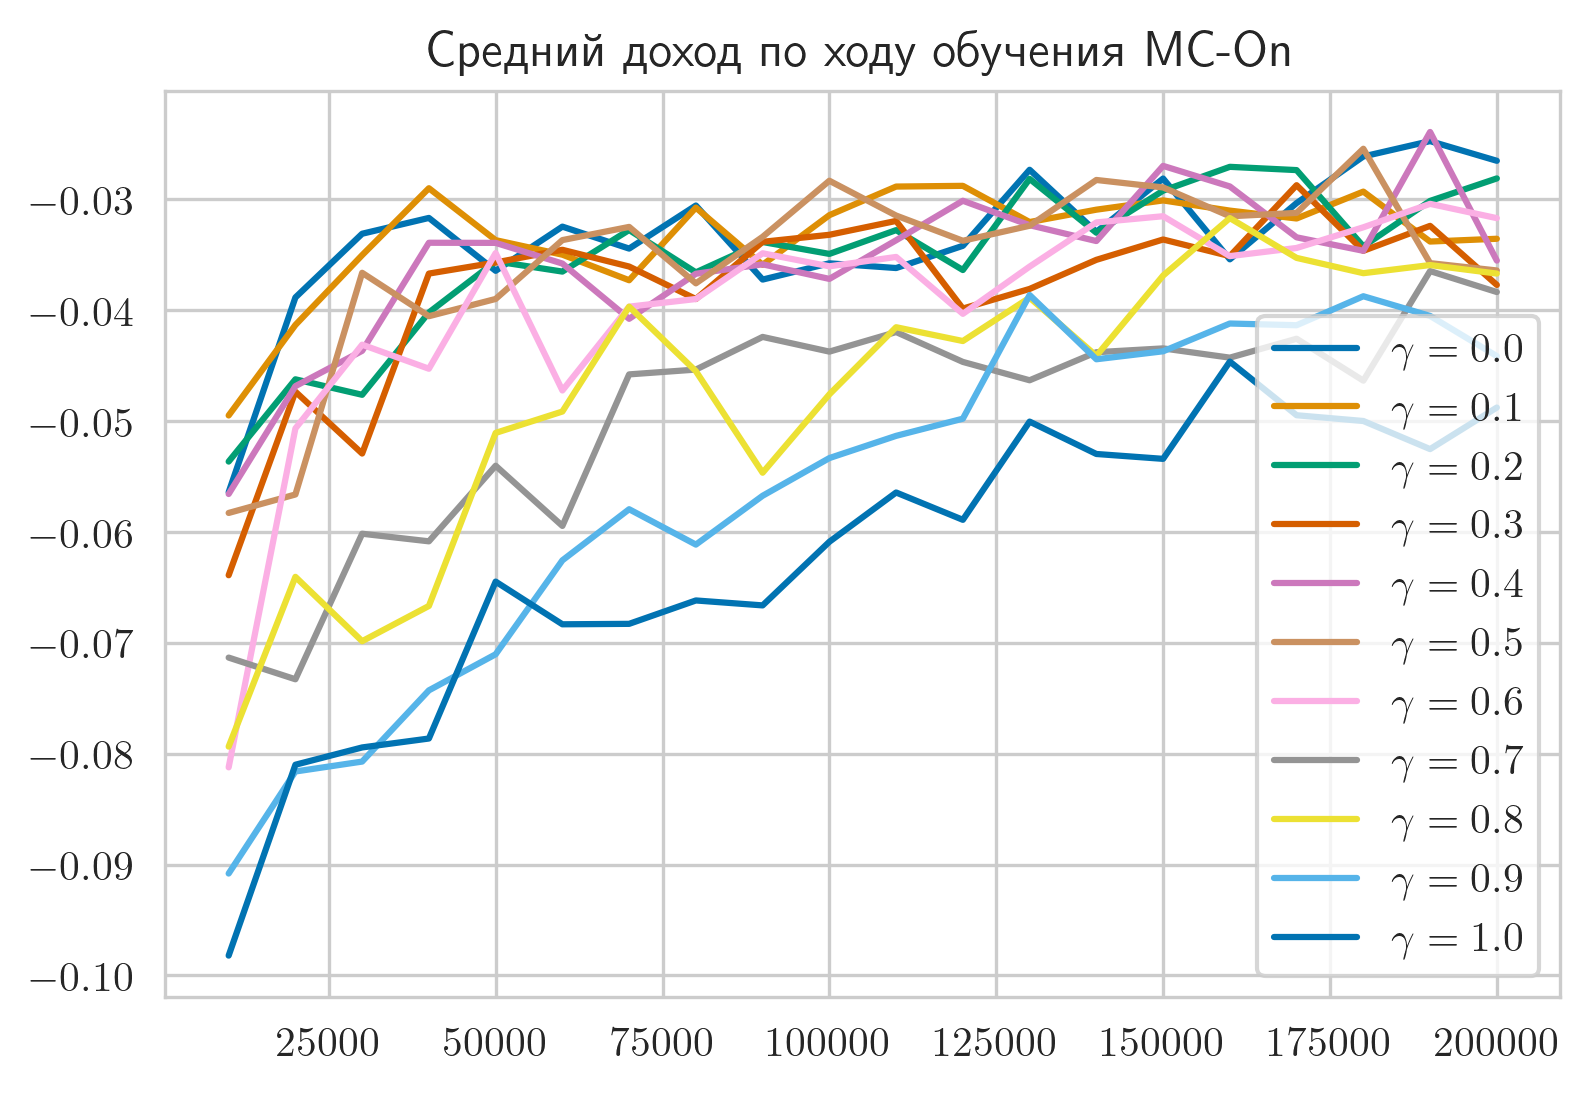

In [45]:
mc_on_algos = [
    {
        'name': '',
        'method': monte_carlo_control_on_policy,
        'method_params': { 'gamma': gamma },
        'eps': eps_decay,
        'eps_params': {}
    } for gamma in np.linspace(0, 1, 11)
]

plot_learning_curve(
    mc_on_algos,
    env = gym.make('Blackjack-v0', natural=True),
    title='Средний доход по ходу обучения MC-On',
    num_experiments=200000,
    score_every=0.05
)

Видим, что алгоритм On-Policy Monte Carlo Control работает лучше, когда $\gamma$ маленькая, поисследуем еще внимательнее

2020-11-07 15:39:58.219992 - Learning {'name': '', 'method': <function monte_carlo_control_on_policy at 0x7fe216df6320>, 'method_params': {'gamma': 0.01}, 'eps': <function eps_decay at 0x7fe21d3294d0>, 'eps_params': {}}
2020-11-07 15:41:18.284553 - Learning {'name': '', 'method': <function monte_carlo_control_on_policy at 0x7fe216df6320>, 'method_params': {'gamma': 0.03111111111111111}, 'eps': <function eps_decay at 0x7fe21d3294d0>, 'eps_params': {}}
2020-11-07 15:42:37.796564 - Learning {'name': '', 'method': <function monte_carlo_control_on_policy at 0x7fe216df6320>, 'method_params': {'gamma': 0.052222222222222225}, 'eps': <function eps_decay at 0x7fe21d3294d0>, 'eps_params': {}}
2020-11-07 15:43:57.342597 - Learning {'name': '', 'method': <function monte_carlo_control_on_policy at 0x7fe216df6320>, 'method_params': {'gamma': 0.07333333333333333}, 'eps': <function eps_decay at 0x7fe21d3294d0>, 'eps_params': {}}
2020-11-07 15:45:16.463349 - Learning {'name': '', 'method': <function mon

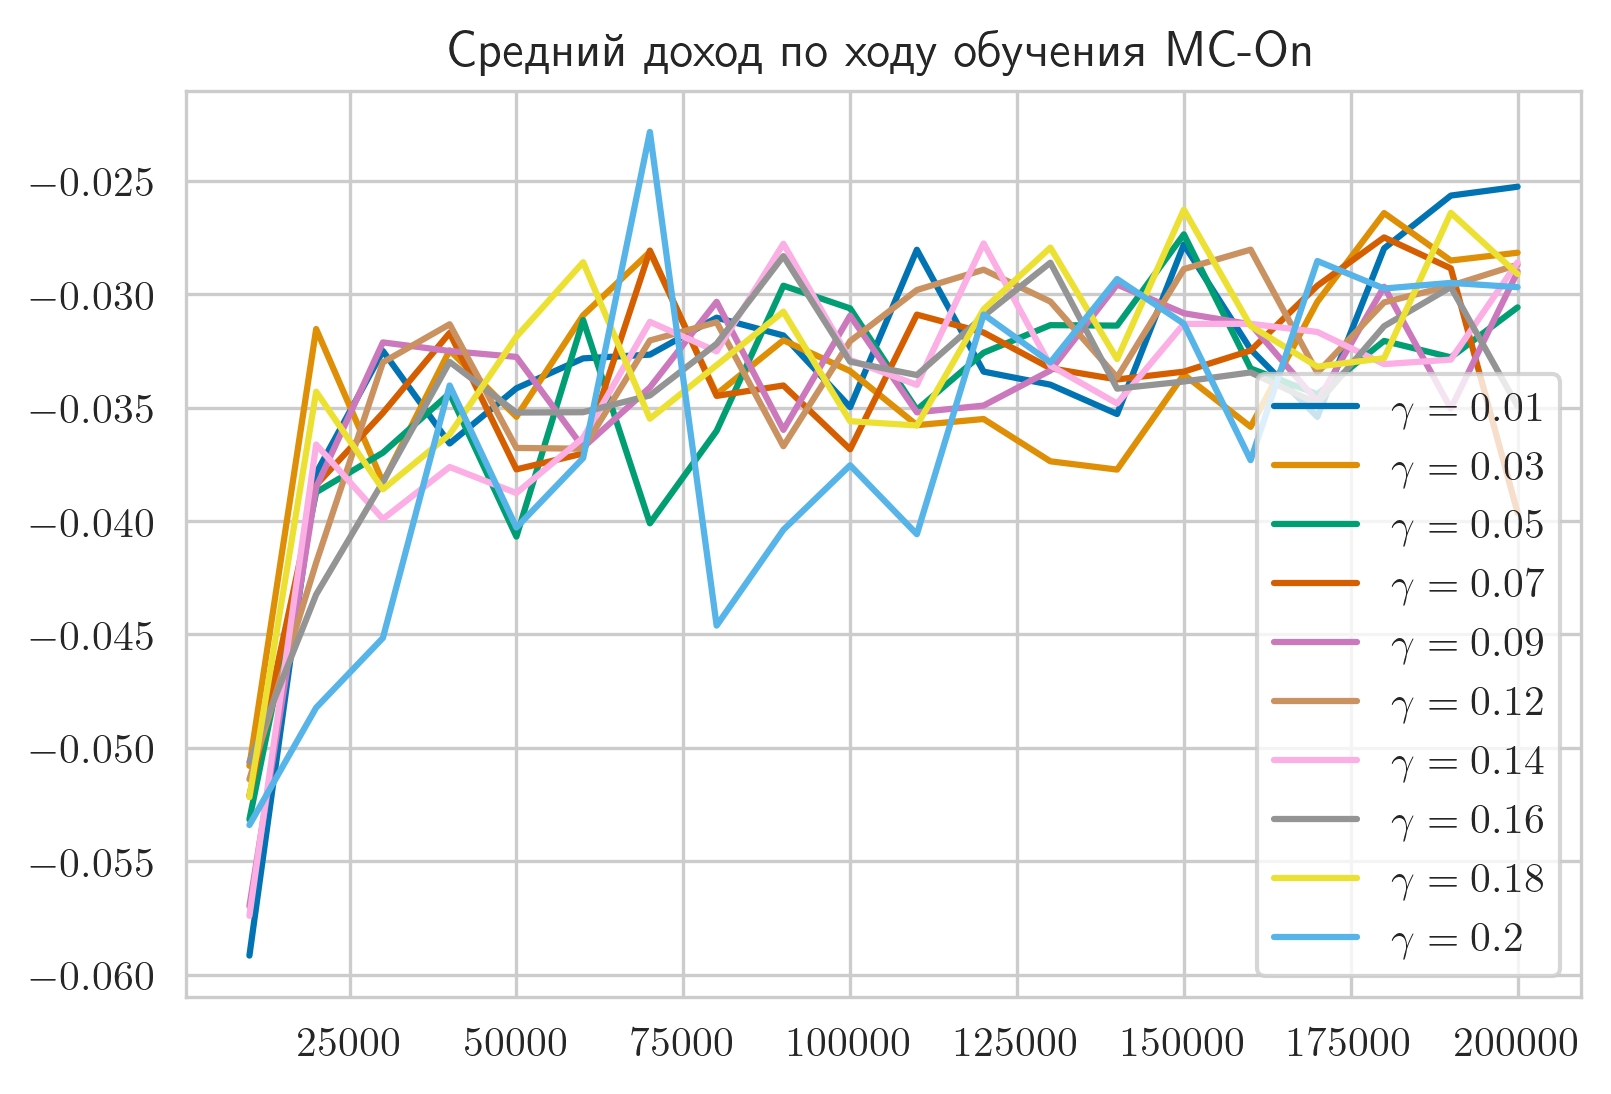

In [46]:
mc_on_algos = [
    {
        'name': '',
        'method': monte_carlo_control_on_policy,
        'method_params': { 'gamma': gamma },
        'eps': eps_decay,
        'eps_params': {}
    } for gamma in np.linspace(0.01, 0.2, 10)
]

plot_learning_curve(
    mc_on_algos,
    env = gym.make('Blackjack-v0', natural=True),
    title='Средний доход по ходу обучения MC-On',
    num_experiments=200000,
    score_every=0.05
)

Лучшие параметры для MC-On:

- $\gamma = 0.01$

Попробуем подобрать параметры для Off-Policy Monte Carlo Control

2020-11-07 15:56:24.456658 - Learning {'name': '', 'method': <function monte_carlo_control_off_policy at 0x7fe21d304c20>, 'method_params': {'gamma': 0.1}, 'eps': <function eps_constant at 0x7fe21d329a70>, 'eps_params': {'epsilon': 0.1}}
2020-11-07 15:57:45.367407 - Learning {'name': '', 'method': <function monte_carlo_control_off_policy at 0x7fe21d304c20>, 'method_params': {'gamma': 0.1}, 'eps': <function eps_constant at 0x7fe21d329a70>, 'eps_params': {'epsilon': 0.3}}
2020-11-07 15:59:05.225276 - Learning {'name': '', 'method': <function monte_carlo_control_off_policy at 0x7fe21d304c20>, 'method_params': {'gamma': 0.1}, 'eps': <function eps_constant at 0x7fe21d329a70>, 'eps_params': {'epsilon': 0.5}}
2020-11-07 16:00:25.168930 - Learning {'name': '', 'method': <function monte_carlo_control_off_policy at 0x7fe21d304c20>, 'method_params': {'gamma': 0.1}, 'eps': <function eps_constant at 0x7fe21d329a70>, 'eps_params': {'epsilon': 0.7}}
2020-11-07 16:01:44.225661 - Learning {'name': '', '

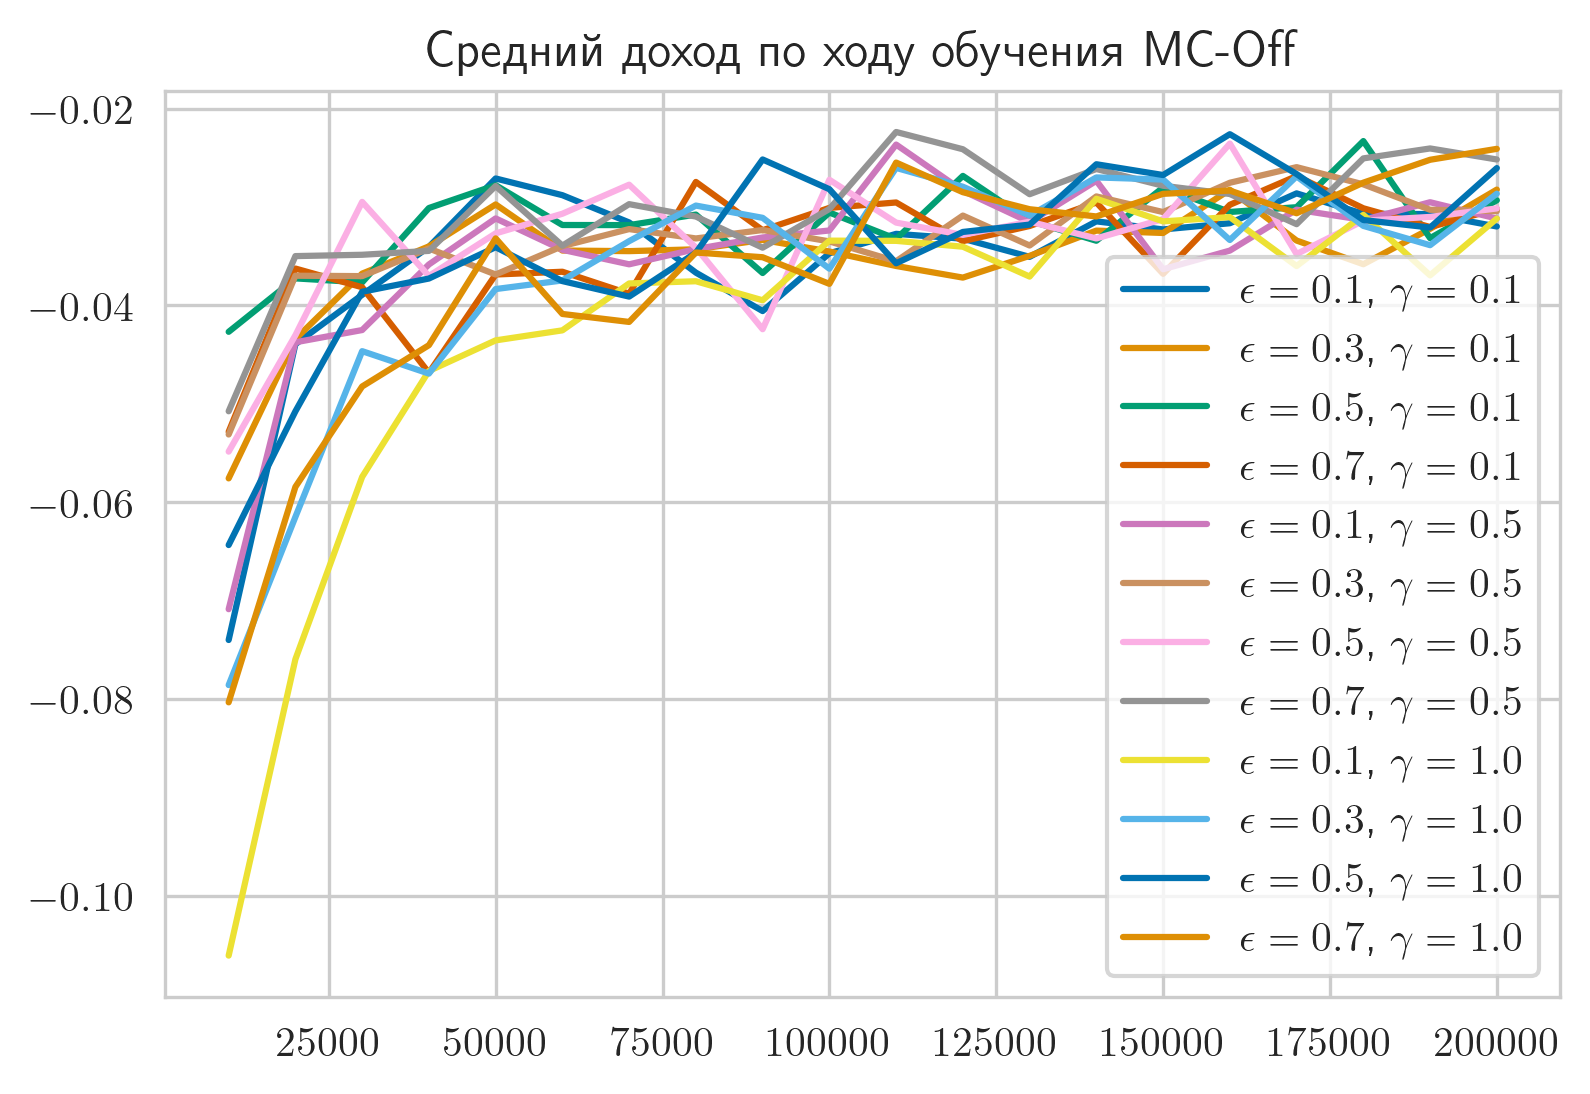

In [50]:
mc_off_algos = [
    {
        'name': '',
        'method': monte_carlo_control_off_policy,
        'method_params': { 'gamma': gamma },
        'eps': eps_constant,
        'eps_params': { 'epsilon': epsilon }
    } for gamma, epsilon in product(
        [0.1, 0.5, 1.0],
        [0.1, 0.3, 0.5, 0.7]
    )
]

plot_learning_curve(
    mc_off_algos,
    env = gym.make('Blackjack-v0', natural=True),
    title='Средний доход по ходу обучения MC-Off',
    num_experiments=200000,
    score_every=0.05
)

2020-11-07 16:23:18.624121 - Learning {'name': '', 'method': <function monte_carlo_control_off_policy at 0x7fe21d304c20>, 'method_params': {'gamma': 0.01}, 'eps': <function eps_constant at 0x7fe21d329a70>, 'eps_params': {'epsilon': 0.5}}
2020-11-07 16:24:39.430445 - Learning {'name': '', 'method': <function monte_carlo_control_off_policy at 0x7fe21d304c20>, 'method_params': {'gamma': 0.03111111111111111}, 'eps': <function eps_constant at 0x7fe21d329a70>, 'eps_params': {'epsilon': 0.5}}
2020-11-07 16:25:58.741830 - Learning {'name': '', 'method': <function monte_carlo_control_off_policy at 0x7fe21d304c20>, 'method_params': {'gamma': 0.052222222222222225}, 'eps': <function eps_constant at 0x7fe21d329a70>, 'eps_params': {'epsilon': 0.5}}
2020-11-07 16:27:18.926146 - Learning {'name': '', 'method': <function monte_carlo_control_off_policy at 0x7fe21d304c20>, 'method_params': {'gamma': 0.07333333333333333}, 'eps': <function eps_constant at 0x7fe21d329a70>, 'eps_params': {'epsilon': 0.5}}
20

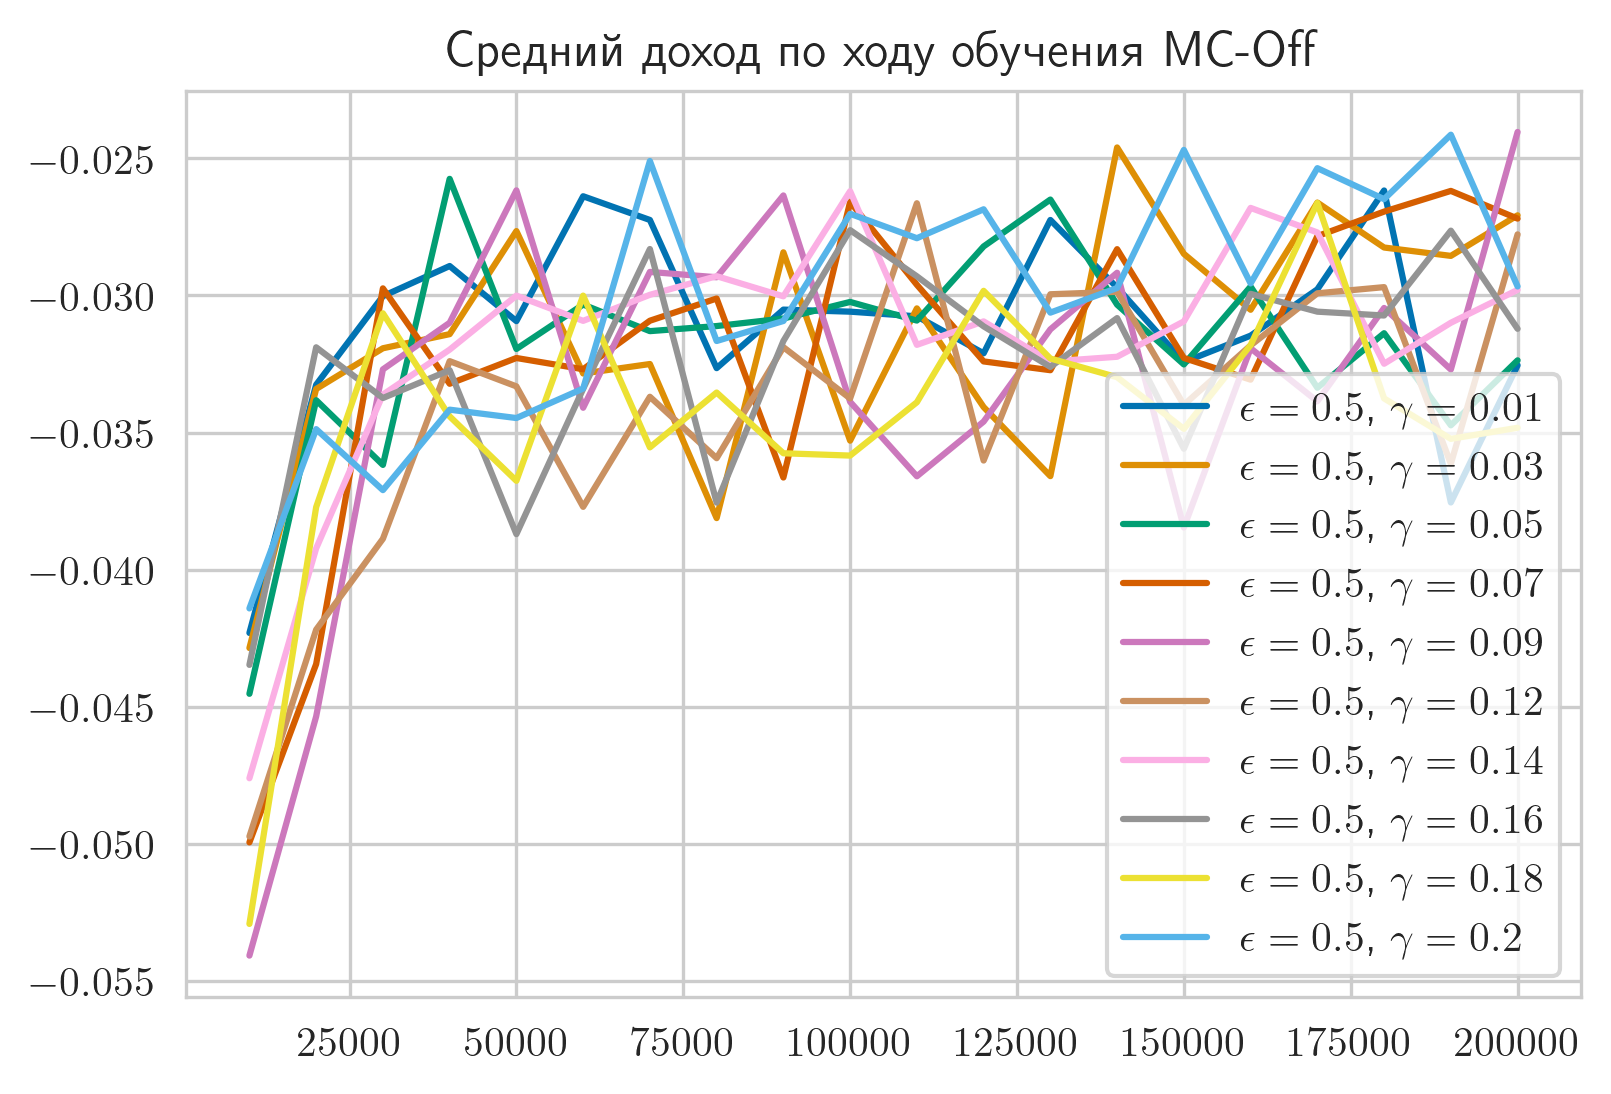

In [53]:
mc_off_algos = [
    {
        'name': '',
        'method': monte_carlo_control_off_policy,
        'method_params': { 'gamma': gamma },
        'eps': eps_constant,
        'eps_params': { 'epsilon': 0.5 }
    } for gamma in np.linspace(0.01, 0.2, 10)
]

plot_learning_curve(
    mc_off_algos,
    env = gym.make('Blackjack-v0', natural=True),
    title='Средний доход по ходу обучения MC-Off',
    num_experiments=200000,
    score_every=0.05
)

Лучшие параметры для MC-Off:

- $\gamma = 0.2$
- $\epsilon = 0.5$

Попробуем подобрать параметры для SARSA

2020-11-07 16:42:04.673728 - Learning {'name': '', 'method': <function sarsa at 0x7fe21d31c7a0>, 'method_params': {'gamma': 0.1, 'alpha': 0.001}, 'eps': <function eps_decay at 0x7fe21d3294d0>, 'eps_params': {}}
2020-11-07 16:43:25.135831 - Learning {'name': '', 'method': <function sarsa at 0x7fe21d31c7a0>, 'method_params': {'gamma': 0.5, 'alpha': 0.001}, 'eps': <function eps_decay at 0x7fe21d3294d0>, 'eps_params': {}}
2020-11-07 16:44:44.824073 - Learning {'name': '', 'method': <function sarsa at 0x7fe21d31c7a0>, 'method_params': {'gamma': 1.0, 'alpha': 0.001}, 'eps': <function eps_decay at 0x7fe21d3294d0>, 'eps_params': {}}
2020-11-07 16:46:03.157428 - Learning {'name': '', 'method': <function sarsa at 0x7fe21d31c7a0>, 'method_params': {'gamma': 0.1, 'alpha': 0.01}, 'eps': <function eps_decay at 0x7fe21d3294d0>, 'eps_params': {}}
2020-11-07 16:47:25.488335 - Learning {'name': '', 'method': <function sarsa at 0x7fe21d31c7a0>, 'method_params': {'gamma': 0.5, 'alpha': 0.01}, 'eps': <func

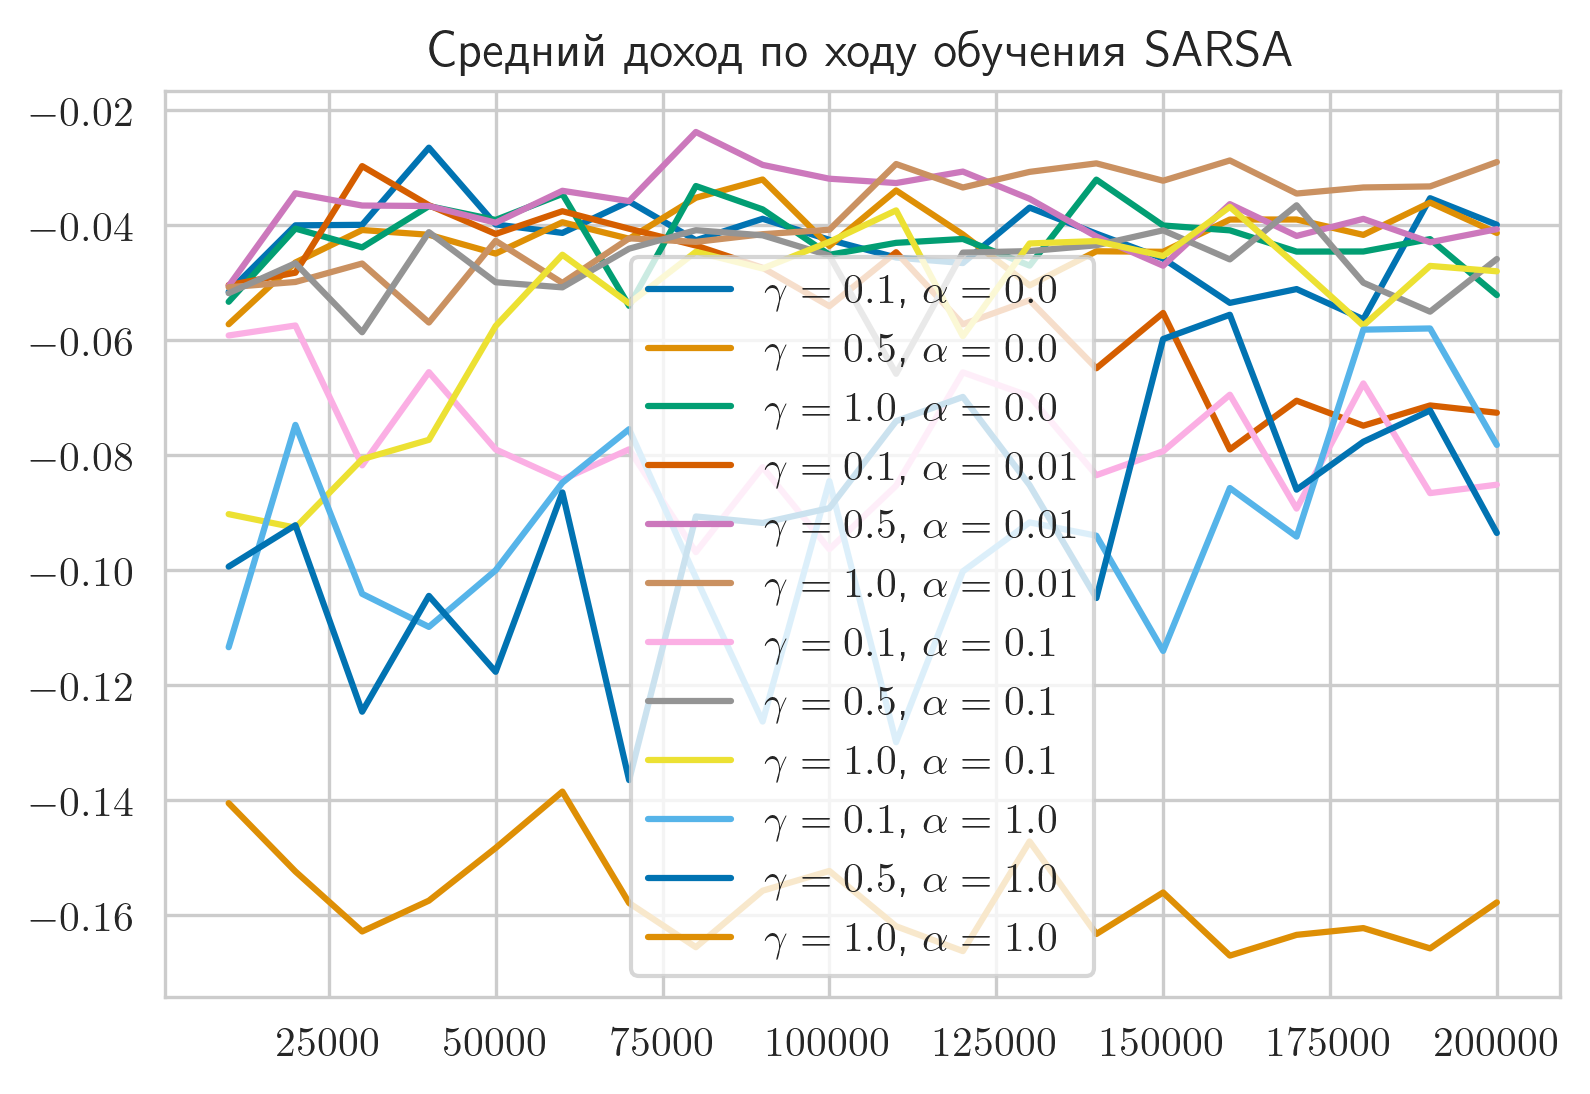

In [59]:
sarsa_algos = [
    {
        'name': '',
        'method': sarsa,
        'method_params': { 'gamma': gamma, 'alpha': alpha },
        'eps': eps_decay,
        'eps_params': {}
    } for alpha, gamma in product(
        [0.001, 0.01, 0.1, 1.0],
        [0.1, 0.5, 1.0]
    )
]

plot_learning_curve(
    sarsa_algos,
    env = gym.make('Blackjack-v0', natural=True),
    title='Средний доход по ходу обучения SARSA',
    num_experiments=200000,
    score_every=0.05
)

Лучшие параметры для SARSA:

- $\gamma = 1.0$
- $\alpha = 0.01$

Попробуем подобрать параметры для Q-Learning

2020-11-07 17:07:20.670806 - Learning {'name': '', 'method': <function q_learning at 0x7fe216e19680>, 'method_params': {'gamma': 0.1, 'alpha': 0.01}, 'eps': <function eps_constant at 0x7fe21d329a70>, 'eps_params': {'epsilon': 0.1}}
2020-11-07 17:08:48.054995 - Learning {'name': '', 'method': <function q_learning at 0x7fe216e19680>, 'method_params': {'gamma': 0.1, 'alpha': 0.01}, 'eps': <function eps_constant at 0x7fe21d329a70>, 'eps_params': {'epsilon': 0.3}}
2020-11-07 17:10:14.643516 - Learning {'name': '', 'method': <function q_learning at 0x7fe216e19680>, 'method_params': {'gamma': 0.1, 'alpha': 0.01}, 'eps': <function eps_constant at 0x7fe21d329a70>, 'eps_params': {'epsilon': 0.5}}
2020-11-07 17:11:45.277011 - Learning {'name': '', 'method': <function q_learning at 0x7fe216e19680>, 'method_params': {'gamma': 0.1, 'alpha': 0.01}, 'eps': <function eps_constant at 0x7fe21d329a70>, 'eps_params': {'epsilon': 0.7}}
2020-11-07 17:13:10.468927 - Learning {'name': '', 'method': <function q

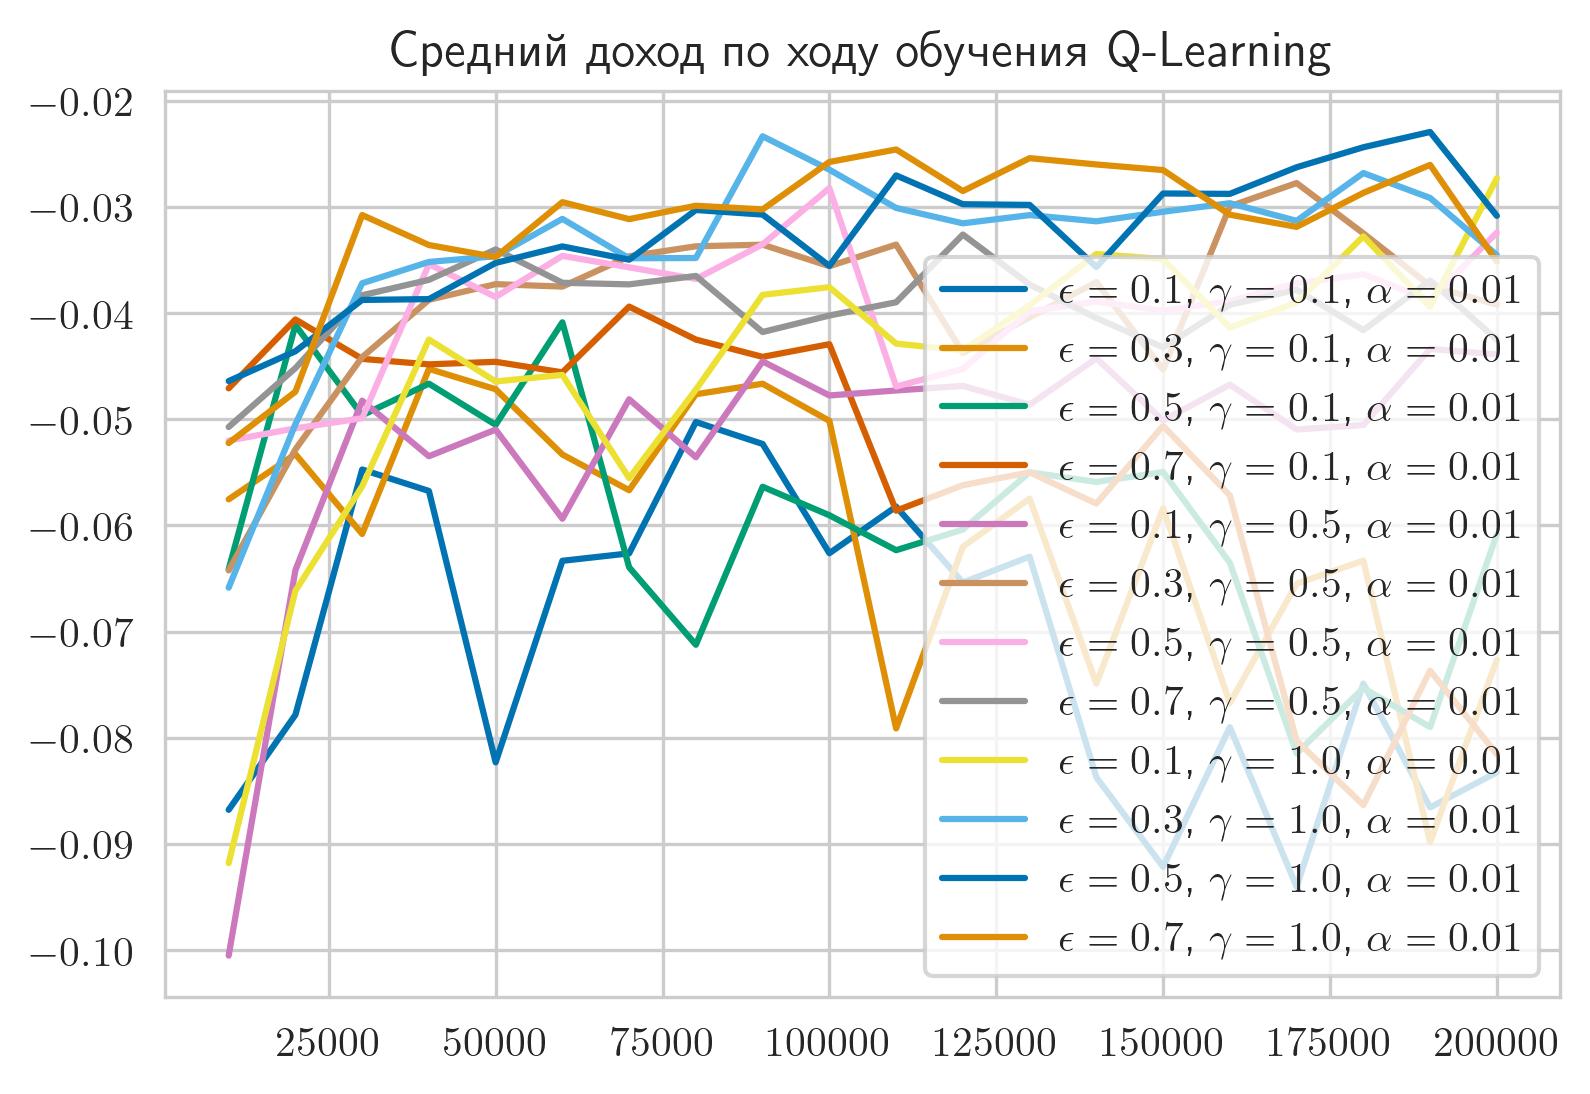

In [60]:
qlearning_algos = [
    {
        'name': '',
        'method': q_learning,
        'method_params': { 'gamma': gamma, 'alpha': 0.01 },
        'eps': eps_constant,
        'eps_params': { 'epsilon': epsilon }
    } for gamma, epsilon in product(
        [0.1, 0.5, 1.0],
        [0.1, 0.3, 0.5, 0.7]
    )
]

plot_learning_curve(
    qlearning_algos,
    env = gym.make('Blackjack-v0', natural=True),
    title='Средний доход по ходу обучения Q-Learning',
    num_experiments=200000,
    score_every=0.05
)

2020-11-07 17:25:17.342311 - Learning {'name': '', 'method': <function q_learning at 0x7fe216e19680>, 'method_params': {'gamma': 0.1, 'alpha': 0.01}, 'eps': <function eps_constant at 0x7fe21d329a70>, 'eps_params': {'epsilon': 0.1}}
2020-11-07 17:26:44.776949 - Learning {'name': '', 'method': <function q_learning at 0x7fe216e19680>, 'method_params': {'gamma': 0.1, 'alpha': 0.01}, 'eps': <function eps_constant at 0x7fe21d329a70>, 'eps_params': {'epsilon': 0.5}}
2020-11-07 17:28:10.624533 - Learning {'name': '', 'method': <function q_learning at 0x7fe216e19680>, 'method_params': {'gamma': 1.0, 'alpha': 0.01}, 'eps': <function eps_constant at 0x7fe21d329a70>, 'eps_params': {'epsilon': 0.1}}
2020-11-07 17:29:33.846431 - Learning {'name': '', 'method': <function q_learning at 0x7fe216e19680>, 'method_params': {'gamma': 1.0, 'alpha': 0.01}, 'eps': <function eps_constant at 0x7fe21d329a70>, 'eps_params': {'epsilon': 0.5}}


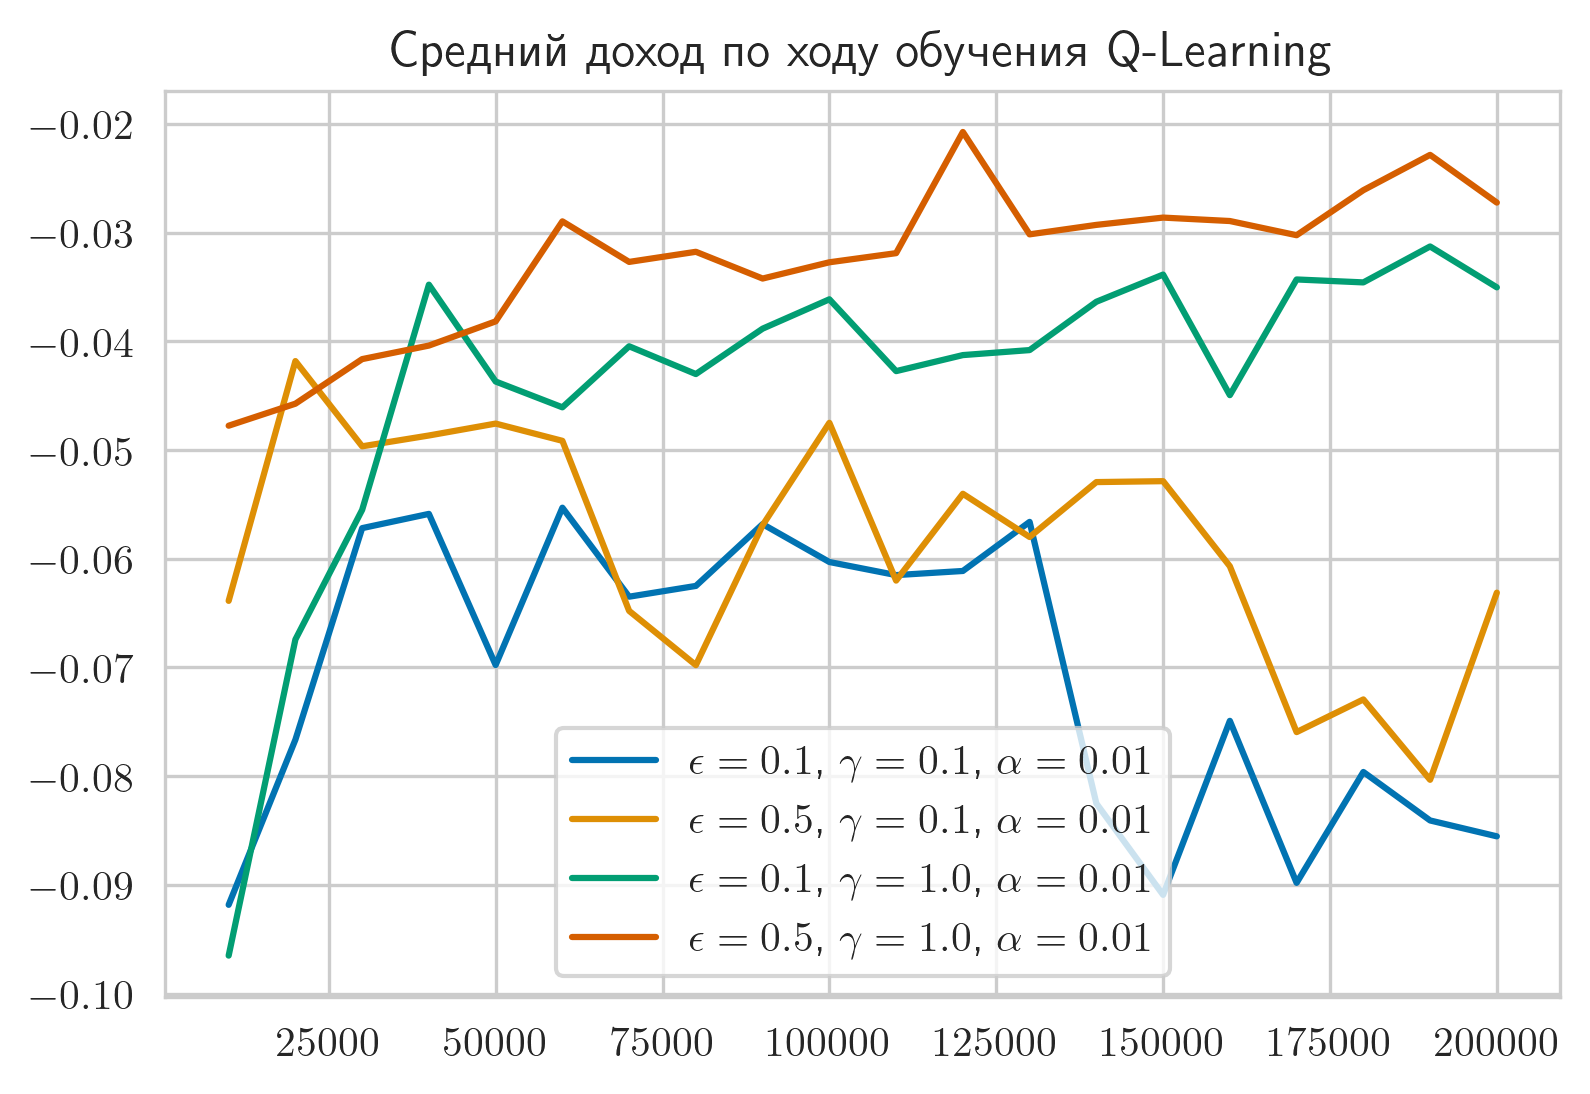

In [62]:
qlearning_algos = [
    {
        'name': '',
        'method': q_learning,
        'method_params': { 'gamma': gamma, 'alpha': 0.01 },
        'eps': eps_constant,
        'eps_params': { 'epsilon': epsilon }
    } for gamma, epsilon in product(
        [0.1, 1.0],
        [0.1, 0.5]
    )
]

plot_learning_curve(
    qlearning_algos,
    env = gym.make('Blackjack-v0', natural=True),
    title='Средний доход по ходу обучения Q-Learning',
    num_experiments=200000,
    score_every=0.05
)

Лучшие параметры для Q-Learning:

- $\gamma = 1.0$
- $\alpha = 0.01$
- $\epsilon = 0.5$

Построим общий график со всеми алгоритмами обучения

2020-11-07 17:40:25.442413 - Learning {'name': 'MC-On', 'method': <function monte_carlo_control_on_policy at 0x7fe216df6320>, 'method_params': {'gamma': 0.01}, 'eps': <function eps_decay at 0x7fe21d3294d0>, 'eps_params': {}}
2020-11-07 17:46:19.612613 - Learning {'name': 'MC-Off', 'method': <function monte_carlo_control_off_policy at 0x7fe21d304c20>, 'method_params': {'gamma': 0.2}, 'eps': <function eps_constant at 0x7fe21d329a70>, 'eps_params': {'epsilon': 0.5}}
2020-11-07 17:52:11.913959 - Learning {'name': 'SARSA', 'method': <function sarsa at 0x7fe21d31c7a0>, 'method_params': {'gamma': 1.0, 'alpha': 0.01}, 'eps': <function eps_decay at 0x7fe21d3294d0>, 'eps_params': {}}
2020-11-07 17:57:52.530306 - Learning {'name': 'Q', 'method': <function q_learning at 0x7fe216e19680>, 'method_params': {'gamma': 1.0, 'alpha': 0.01}, 'eps': <function eps_constant at 0x7fe21d329a70>, 'eps_params': {'epsilon': 0.5}}


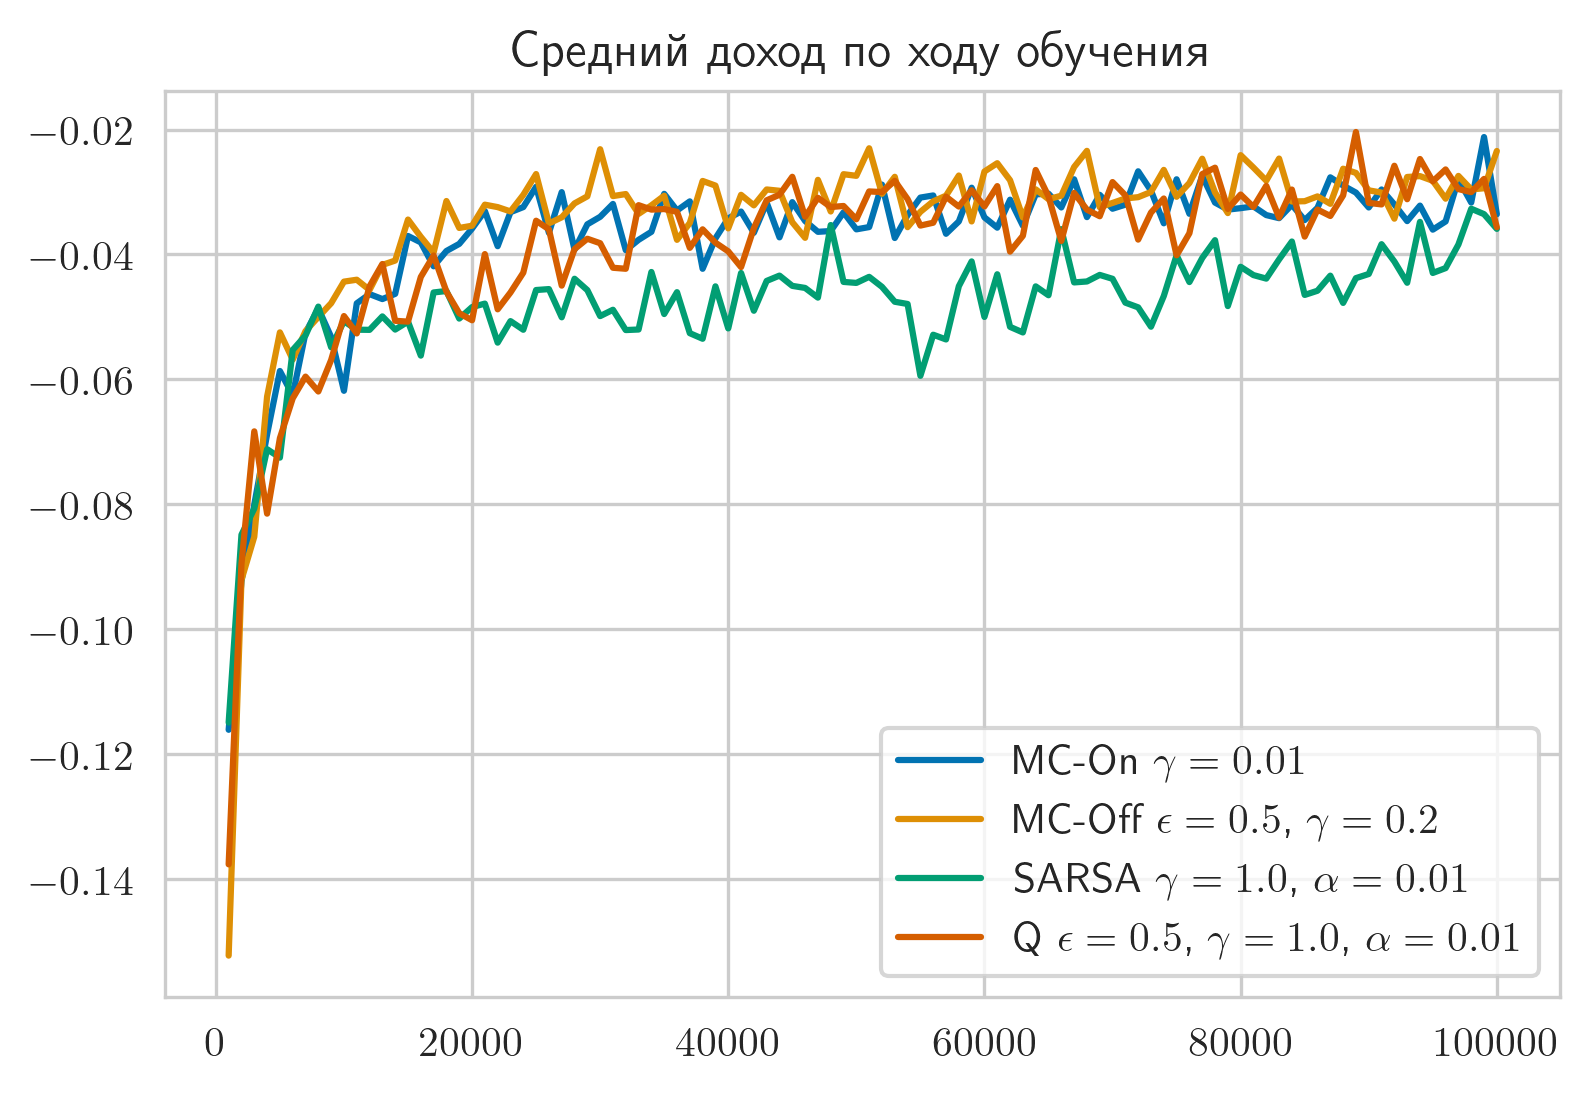

In [65]:
algorithms = [
    {
        'name': 'MC-On',
        'method': monte_carlo_control_on_policy,
        'method_params': { 'gamma': 0.01 },
        'eps': eps_decay,
        'eps_params': {}
    },
    {
        'name': 'MC-Off',
        'method': monte_carlo_control_off_policy,
        'method_params': { 'gamma': 0.2 },
        'eps': eps_constant,
        'eps_params': { 'epsilon': 0.5 }
    },
    {
        'name': 'SARSA',
        'method': sarsa,
        'method_params': { 'gamma': 1.0, 'alpha': 0.01 },
        'eps': eps_decay,
        'eps_params': {}
    },
    {
        'name': 'Q',
        'method': q_learning,
        'method_params': { 'gamma': 1.0, 'alpha': 0.01 },
        'eps': eps_constant,
        'eps_params': { 'epsilon': 0.5 }
    },
]

plot_learning_curve(
    algorithms,
    env = gym.make('Blackjack-v0', natural=True),
    title='Средний доход по ходу обучения',
    num_experiments=100000,
    score_every=0.01
)

На итоговом графике можно увидеть, что лучший результат показывают алгоритмы Q-learning и MC-Off-Policy, поскольку они позволяют выучивать нам наилучшую жесткую стратегию.

Почему почти во всех алгоритмах небольшое значение гамма? В целом все эти игры имеют не очень большую длину эпизода, а процесс, который происходит в этой игре имеет сильно стохастическую природу, однако действия пользователя всё-таки играют какую-то роль, поэтому гамма не совсем нулевая.

## Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:

* **double** — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

### 4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

BlackjackDoubleEnv объявлен в файле `blackjack_with_double.py`
Данный код использует базовый класс Blackjack-v0, в него простым образом добавляется одно действие - DOUBLE.

In [66]:
from gym.envs.registration import register
from blackjack_with_double import BlackjackDoubleEnv

gym.envs.toy_text.blackjack.BlackjackDoubleEnv = BlackjackDoubleEnv

register(
    id='BlackjackDoubleEnv-v0',
    entry_point='gym.envs.toy_text.blackjack:BlackjackDoubleEnv',
)

Проверим, что функции игры все еще работают

In [67]:
blackjack_episode(policy_random(), env=gym.make('BlackjackDoubleEnv-v0', natural=True), random_state=3, verbose=True)

Стартовая раздача: (6, 10, False)
Берем карту
Текущая раздача: (12, 10, False), текущая награда: 0.0
Берем карту
Текущая раздача: (15, 10, False), текущая награда: 0.0
Берем карту
Текущая раздача: (18, 10, False), текущая награда: 0.0
Удваиваем
Текущая раздача: (28, 10, False), текущая награда: -2.0


([(6, 10, False), (12, 10, False), (15, 10, False), (18, 10, False)],
 [1, 1, 1, 2],
 [0.0, 0.0, 0.0, -2.0])

Посчитаем средний выигрыш при случайной стратегии

In [69]:
calculate_reward_by_policy(
    policy_random(),
    env=gym.make('BlackjackDoubleEnv-v0', natural=True),
    num_experiments=100000,
    random_state=42
)

-0.560895

### 5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

2020-11-07 19:01:54.697982 - Learning {'name': 'MC-On', 'method': <function monte_carlo_control_on_policy at 0x7fe215df1290>, 'method_params': {'gamma': 0.01}, 'eps': <function eps_decay at 0x7fe21d3294d0>, 'eps_params': {}}
2020-11-07 19:08:39.560585 - Learning {'name': 'MC-Off', 'method': <function monte_carlo_control_off_policy at 0x7fe215df1cb0>, 'method_params': {'gamma': 0.2}, 'eps': <function eps_constant at 0x7fe21d329a70>, 'eps_params': {'epsilon': 0.5}}
2020-11-07 19:15:20.902714 - Learning {'name': 'SARSA', 'method': <function sarsa at 0x7fe215dfbcb0>, 'method_params': {'gamma': 1.0, 'alpha': 0.01}, 'eps': <function eps_decay at 0x7fe21d3294d0>, 'eps_params': {}}
2020-11-07 19:22:05.340583 - Learning {'name': 'Q', 'method': <function q_learning at 0x7fe215e997a0>, 'method_params': {'gamma': 1.0, 'alpha': 0.01}, 'eps': <function eps_constant at 0x7fe21d329a70>, 'eps_params': {'epsilon': 0.5}}


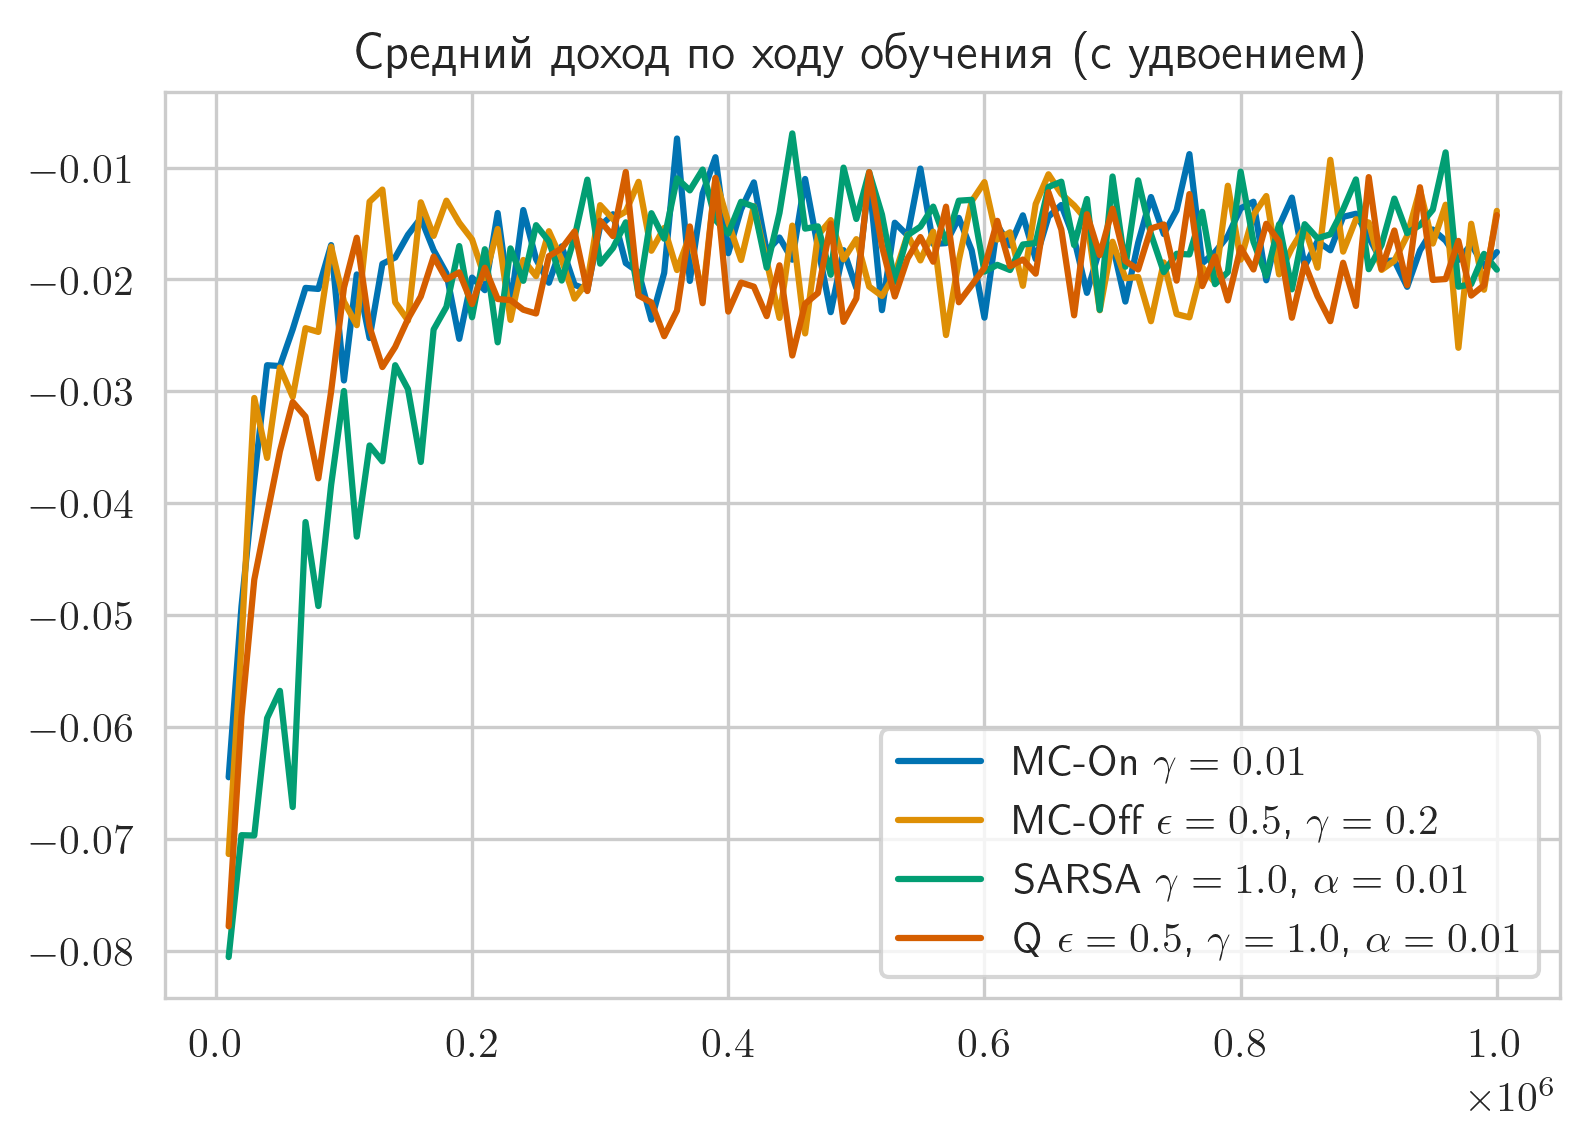

In [92]:
algorithms = [
    {
        'name': 'MC-On',
        'method': monte_carlo_control_on_policy,
        'method_params': { 'gamma': 0.01 },
        'eps': eps_decay,
        'eps_params': {}
    },
    {
        'name': 'MC-Off',
        'method': monte_carlo_control_off_policy,
        'method_params': { 'gamma': 0.2 },
        'eps': eps_constant,
        'eps_params': { 'epsilon': 0.5 }
    },
    {
        'name': 'SARSA',
        'method': sarsa,
        'method_params': { 'gamma': 1.0, 'alpha': 0.01 },
        'eps': eps_decay,
        'eps_params': {}
    },
    {
        'name': 'Q',
        'method': q_learning,
        'method_params': { 'gamma': 1.0, 'alpha': 0.01 },
        'eps': eps_constant,
        'eps_params': { 'epsilon': 0.5 }
    },
]

plot_learning_curve(
    algorithms,
    env = gym.make('BlackjackDoubleEnv-v0', natural=True),
    title='Средний доход по ходу обучения (с удвоением)',
    num_experiments=1000000,
    score_every=0.01
)

In [93]:
%%time
Q_star_qlearning, _ = q_learning(
    eps_constant(0.5),
    env=gym.make('BlackjackDoubleEnv-v0', natural=True),
    num_experiments=1000000,
    random_state=42,
    gamma=1.0,
    alpha=0.01
)

CPU times: user 1min 10s, sys: 855 ms, total: 1min 11s
Wall time: 1min 10s


In [94]:
dict(random.sample(Q_star_qlearning.items(), 5))

{(14, 4, False): array([-0.25235649, -0.39243384, -5.06680933]),
 (12, 2, False): array([-0.86948669, -0.27813173, -3.73864202]),
 (17, 2, False): array([ -0.22556259,  -1.45859321, -10.48132289]),
 (12, 1, False): array([-3.5961703, -0.5178307, -9.1212839]),
 (14, 5, True): array([-0.51105681,  0.16357883,  0.06417224])}

In [95]:
calculate_reward_by_policy(
    policy_q(Q_star_qlearning, 0.0),
    env=gym.make('BlackjackDoubleEnv-v0', natural=True),
    num_experiments=1000000,
    random_state=42
)

-0.0172555

Видим, что добавление DOUBLE чуть-чуть улучшает наш скор.

## Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

### 6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет [статья википедии о блекджеке](https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA) (а возможно, и нет).


BlackjackDoubleCountingEnv объявлен в файле `blackjack_with_double_counting.py`

Подсчет карт осуществлялся по методу ["Половинки"](https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA#%D0%9F%D0%BE%D0%B4%D1%81%D1%87%D1%91%D1%82_%D0%BA%D0%B0%D1%80%D1%82).

Мне показалось, что очень хорошо подсчет карт описан [здесь](https://game-wiki.guru/published/blekdzhek/blekdzhek.-sistemyi-scheta-kart.html).
Суть заключается в том, что каждой карте присваивается какой-то балл (положительный, или отрицательный), когда игрок видит карту (свою, или дилера), он ведет подсчет баллов.

Далее происходит тонкий момент - игрок должен научиться прикидывать число оставшихся колод в стопке. В реальности это число дробное, но можно ограничиться и целым числом колод. После этого полученный счет делится на число колод, таким образом получается так называемый "реальный счет". Этот счет скоррелирован с вероятностью вытащить хорошую карту, поэтому мы просто добавим это число к нашему состоянию.

In [96]:
from gym.envs.registration import register
from blackjack_with_double_counting import BlackjackDoubleCountingEnv

gym.envs.toy_text.blackjack.BlackjackDoubleCountingEnv = BlackjackDoubleCountingEnv

register(
    id='BlackjackDoubleCountingEnv-v0',
    entry_point='gym.envs.toy_text.blackjack:BlackjackDoubleCountingEnv',
)

In [100]:
blackjack_episode(policy_random(), env=gym.make('BlackjackDoubleCountingEnv-v0', natural=True), random_state=3, verbose=True)

Стартовая раздача: (15, 2, False, 1.0)
Берем карту
Текущая раздача: (21, 2, False, 2.0), текущая награда: 0.0
Берем карту
Текущая раздача: (25, 2, False, 4.5), текущая награда: -1.0


([(15, 2, False, 1.0), (21, 2, False, 2.0)], [1, 1], [0.0, -1.0])

In [228]:
calculate_reward_by_policy(
    policy_random(),
    env=gym.make('BlackjackDoubleCountingEnv-v0', natural=True, num_decks=1),
    num_experiments=100000,
    random_state=42
)

-0.558475

### 7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

2020-11-07 23:28:41.401129 - Learning {'name': 'MC-On', 'method': <function monte_carlo_control_on_policy at 0x7fe215df1290>, 'method_params': {'gamma': 0.01}, 'eps': <function <lambda> at 0x7fe20f36be60>, 'eps_params': {}}
2020-11-07 23:36:25.552510 - Learning {'name': 'MC-Off', 'method': <function monte_carlo_control_off_policy at 0x7fe215df1cb0>, 'method_params': {'gamma': 0.2}, 'eps': <function eps_constant at 0x7fe21d329a70>, 'eps_params': {'epsilon': 0.5}}
2020-11-07 23:43:53.185942 - Learning {'name': 'SARSA', 'method': <function sarsa at 0x7fe215dfbcb0>, 'method_params': {'gamma': 1.0, 'alpha': 0.01}, 'eps': <function <lambda> at 0x7fe20f36bef0>, 'eps_params': {}}
2020-11-07 23:51:17.621816 - Learning {'name': 'Q', 'method': <function q_learning at 0x7fe215e997a0>, 'method_params': {'gamma': 1.0, 'alpha': 0.01}, 'eps': <function eps_constant at 0x7fe21d329a70>, 'eps_params': {'epsilon': 0.5}}


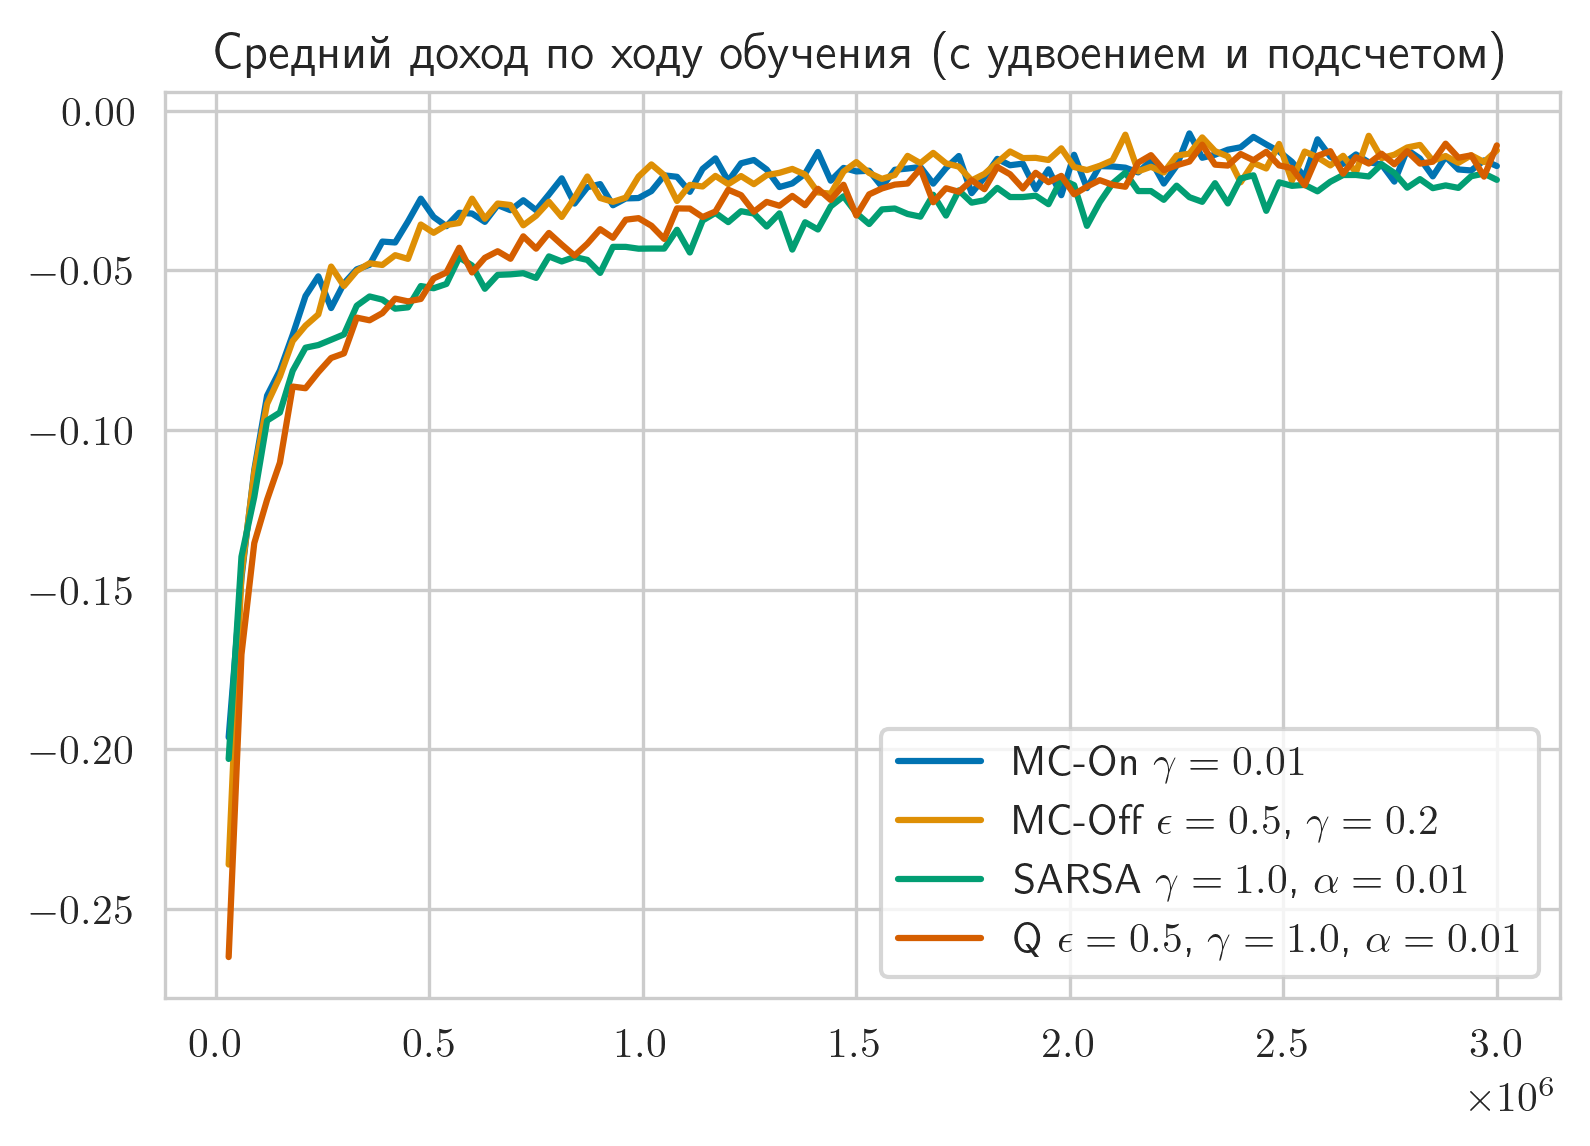

In [229]:
algorithms = [
    {
        'name': 'MC-On',
        'method': monte_carlo_control_on_policy,
        'method_params': { 'gamma': 0.01 },
        'eps': lambda: eps_decay(decay=0.01 ** (1 / 3000000)),
        'eps_params': {}
    },
    {
        'name': 'MC-Off',
        'method': monte_carlo_control_off_policy,
        'method_params': { 'gamma': 0.2 },
        'eps': eps_constant,
        'eps_params': { 'epsilon': 0.5 }
    },
    {
        'name': 'SARSA',
        'method': sarsa,
        'method_params': { 'gamma': 1.0, 'alpha': 0.01 },
        'eps': lambda: eps_decay(decay=0.01 ** (1 / 3000000)),
        'eps_params': {}
    },
    {
        'name': 'Q',
        'method': q_learning,
        'method_params': { 'gamma': 1.0, 'alpha': 0.01 },
        'eps': eps_constant,
        'eps_params': { 'epsilon': 0.5 }
    },
]

plot_learning_curve(
    algorithms,
    env = gym.make('BlackjackDoubleCountingEnv-v0', natural=True, num_decks=1),
    title='Средний доход по ходу обучения (с удвоением и подсчетом)',
    num_experiments=3000000,
    score_every=0.01
)

In [230]:
%%time
Q_star_qlearning, _ = q_learning(
    eps_constant(0.5),
    env=gym.make('BlackjackDoubleCountingEnv-v0', natural=True, num_decks=1),
    num_experiments=1000000,
    random_state=None,
    gamma=1.0,
    alpha=0.01
)

CPU times: user 1min 2s, sys: 709 ms, total: 1min 3s
Wall time: 1min 3s


In [231]:
dict(random.sample(Q_star_qlearning.items(), 5))

{(18, 6, False, 4.0): array([ 0.24344012, -0.21507339, -0.25417601]),
 (6, 5, False, -7.5): array([ 0.01  ,    -inf, -0.0201]),
 (13, 6, False, 8.0): array([-0.0199    , -0.02174641, -0.02367573]),
 (7, 6, False, -4.0): array([-0.03076876, -0.00052998,  0.05670897]),
 (5,
  2,
  False,
  6.5): array([-1.00000000e-04,  2.18216157e-03, -4.88116964e-06])}

In [241]:
calculate_reward_by_policy(
    policy_q(Q_star_qlearning, 0.0),
    env=gym.make('BlackjackDoubleCountingEnv-v0', natural=True, num_decks=1),
    num_experiments=1000000,
    random_state=42
)

-0.0324715

Видим, что от добавления подсчета лучше не становится. Предполагаю, что пространство состояний стало больше и нужно сильно больше итераций, чтобы алгоритм сошелся лушче.

## Часть четвёртая, опциональная

### 9. Реализуйте вариант из второй или третьей части, в котором есть ещё возможность делать split: в случае, когда игроку пришли две одинаковые карты, он может разбить руку на две, внести ещё одну ставку и продолжать играть две руки сразу (как будто за двоих игроков). Скорее всего, обыграть казино получится только в варианте с разрешённым split’ом и подсчётом карт; если получится, это будет отличное завершение проекта!


BlackjackDoubleCountingSplitEnv объявлен в файле `blackjack_with_double_counting_split.py`

Возможность SPLIT'а реализована таким образом, что после ее осуществления игрок играет сперва левой рукой, затем правой. После того, как игрок закончил с обеими руками ход переходит к дилеру.

Если игрок перебрал, то он получает отрицательный ревард мгновенно.

In [242]:
from gym.envs.registration import register
from blackjack_with_double_counting_split import BlackjackDoubleCountingSplitEnv

gym.envs.toy_text.blackjack.BlackjackDoubleCountingSplitEnv = BlackjackDoubleCountingSplitEnv

register(
    id='BlackjackDoubleCountingSplitEnv-v0',
    entry_point='gym.envs.toy_text.blackjack:BlackjackDoubleCountingSplitEnv',
)

In [244]:
blackjack_episode(policy_random(), env=gym.make('BlackjackDoubleCountingSplitEnv-v0', natural=True), random_state=3, verbose=True)

Стартовая раздача: (16, False, 0, False, 4, True, 0.16666666666666666)
Делаем split
Текущая раздача: (10, False, 18, False, 4, False, 0.08333333333333333), текущая награда: 0.0
Берем карту
Текущая раздача: (20, False, 18, False, 4, False, -0.08333333333333333), текущая награда: 0.0
Берем карту
Текущая раздача: (24, False, 18, False, 4, False, 0.08333333333333333), текущая награда: -1.0
Берем карту
Текущая раздача: (24, False, 28, False, 4, False, 0.08333333333333333), текущая награда: -2.0


([(16, False, 0, False, 4, True, 0.16666666666666666),
  (10, False, 18, False, 4, False, 0.08333333333333333),
  (20, False, 18, False, 4, False, -0.08333333333333333),
  (24, False, 18, False, 4, False, 0.08333333333333333)],
 [3, 1, 1, 1],
 [0.0, 0.0, -1.0, -2.0])

Посмотрим, как растет качество обучения с **удвоением, подсчетом и сплитом** при использовании алгоритма Monte-Carlo On-Policy Control

2020-11-08 00:48:17.356679 - Learning {'name': 'MC-On', 'method': <function monte_carlo_control_on_policy at 0x7fe215df1290>, 'method_params': {'gamma': 0.01}, 'eps': <function <lambda> at 0x7fe20eb6b5f0>, 'eps_params': {}}


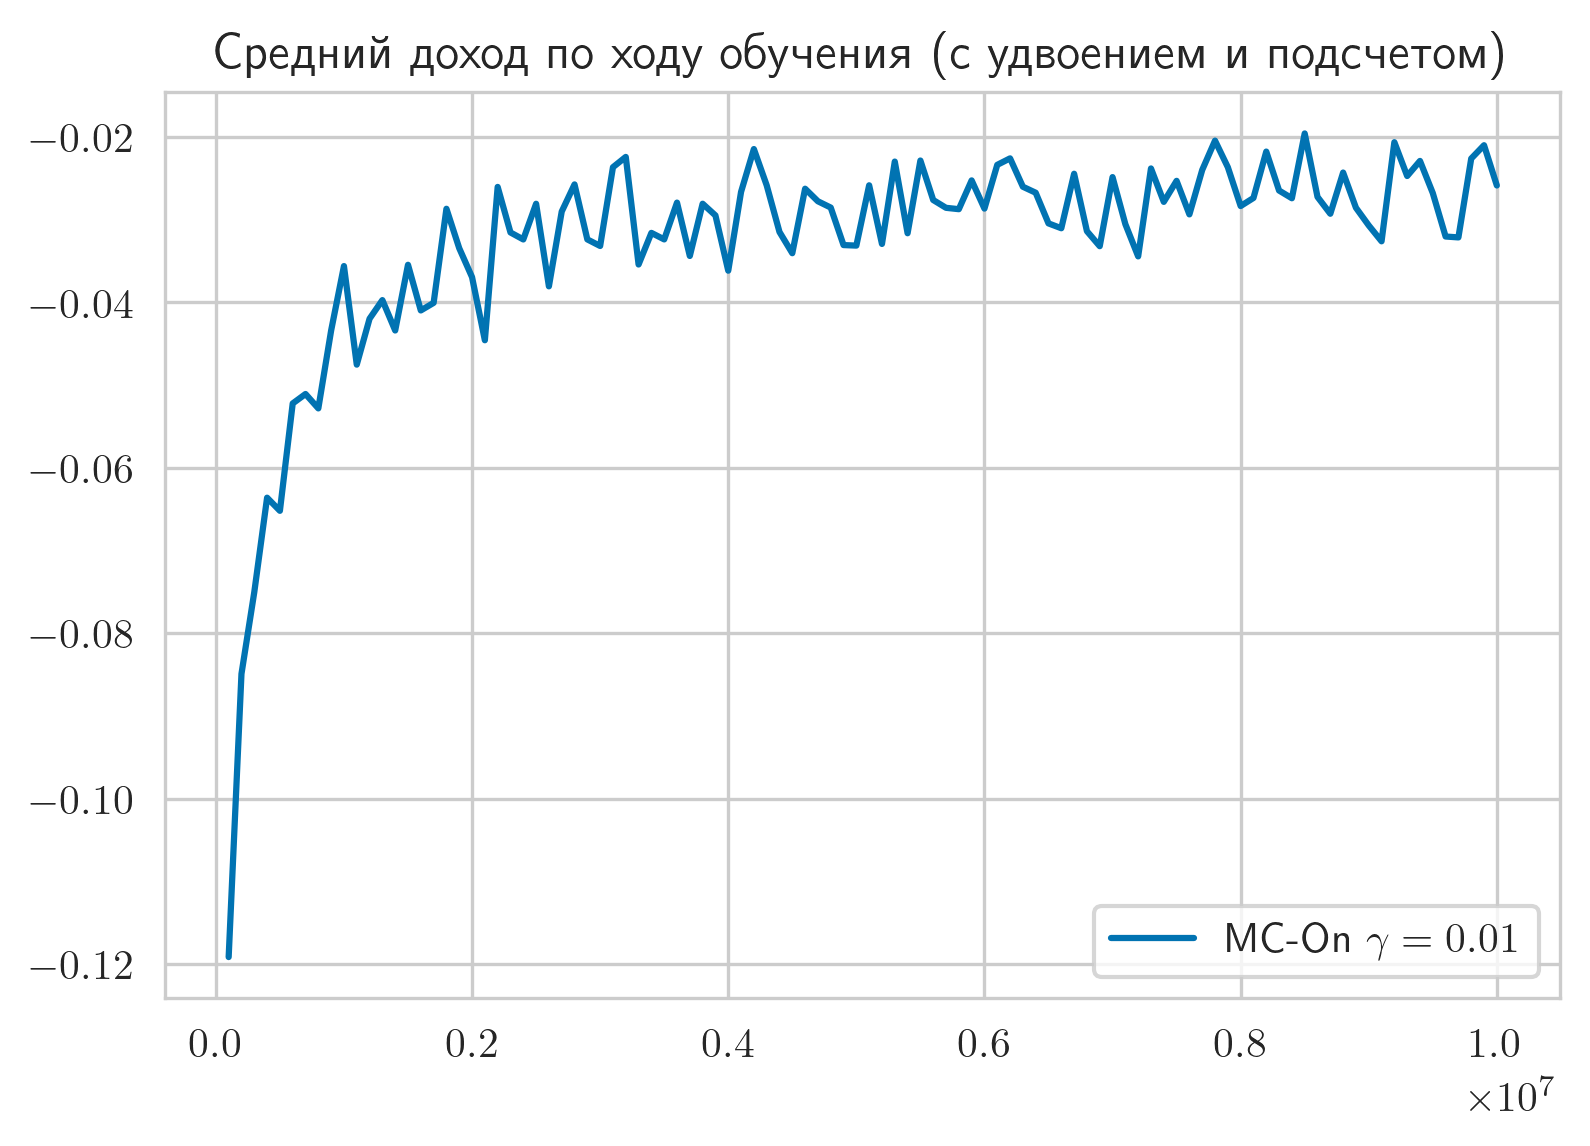

In [260]:
algorithms = [
    {
        'name': 'MC-On',
        'method': monte_carlo_control_on_policy,
        'method_params': { 'gamma': 0.01 },
        'eps': lambda: eps_decay(decay=0.01 ** (1 / 10000000)),
        'eps_params': {}
    },
]

plot_learning_curve(
    algorithms,
    env = gym.make('BlackjackDoubleCountingSplitEnv-v0', natural=True, num_decks=1),
    title='Средний доход по ходу обучения (с удвоением и подсчетом)',
    num_experiments=10000000,
    score_every=0.01
)

Посмотрим, как растет качество обучения с **удвоением, подсчетом и сплитом** при использовании алгоритма Monte-Carlo Off-Policy Control

2020-11-08 01:03:59.131594 - Learning {'name': 'MC-Off', 'method': <function monte_carlo_control_off_policy at 0x7fe20c0c7b90>, 'method_params': {'gamma': 0.2}, 'eps': <function eps_constant at 0x7fe21d329a70>, 'eps_params': {'epsilon': 0.5}}


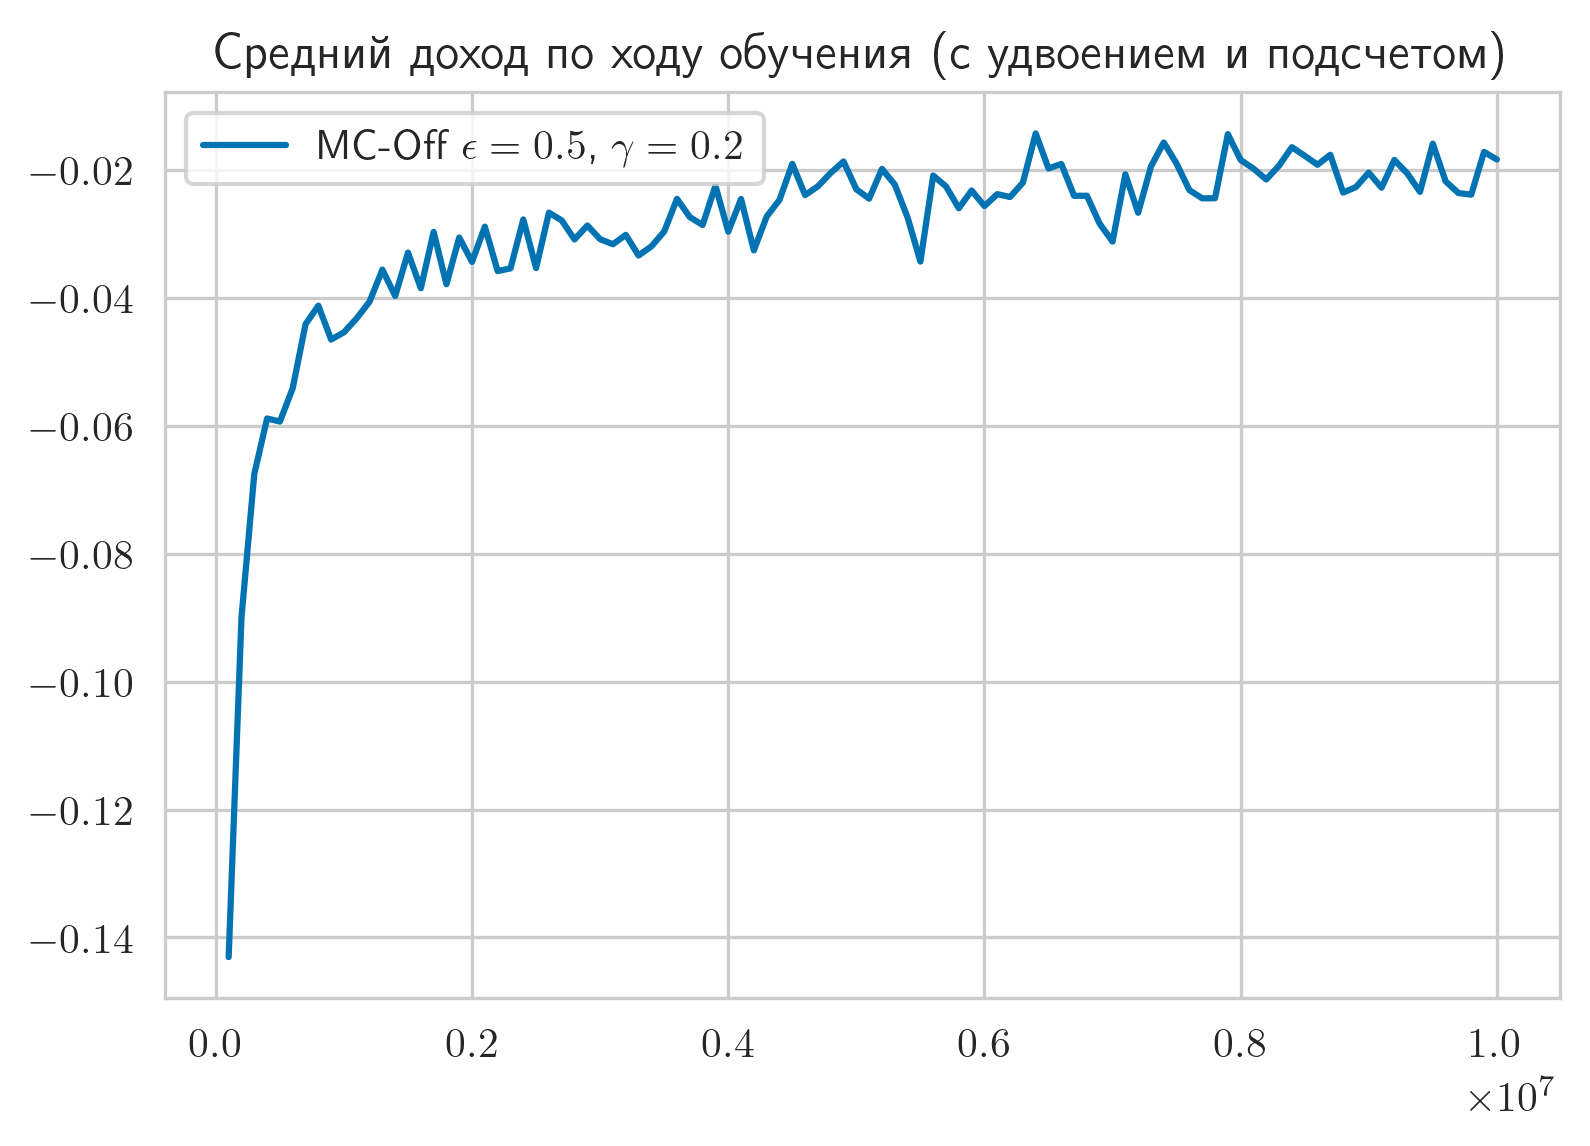

In [261]:
algorithms = [
    {
        'name': 'MC-Off',
        'method': monte_carlo_control_off_policy,
        'method_params': { 'gamma': 0.2 },
        'eps': eps_constant,
        'eps_params': { 'epsilon': 0.5 }
    },
]

plot_learning_curve(
    algorithms,
    env = gym.make('BlackjackDoubleCountingSplitEnv-v0', natural=True, num_decks=1),
    title='Средний доход по ходу обучения (с удвоением и подсчетом)',
    num_experiments=10000000,
    score_every=0.01
)

Посмотрим, как растет качество обучения с **удвоением, подсчетом и сплитом** при использовании алгоритма SARSA

2020-11-08 01:19:20.239159 - Learning {'name': 'SARSA', 'method': <function sarsa at 0x7fe215dfbcb0>, 'method_params': {'gamma': 1.0, 'alpha': 0.01}, 'eps': <function <lambda> at 0x7fe20a572560>, 'eps_params': {}}


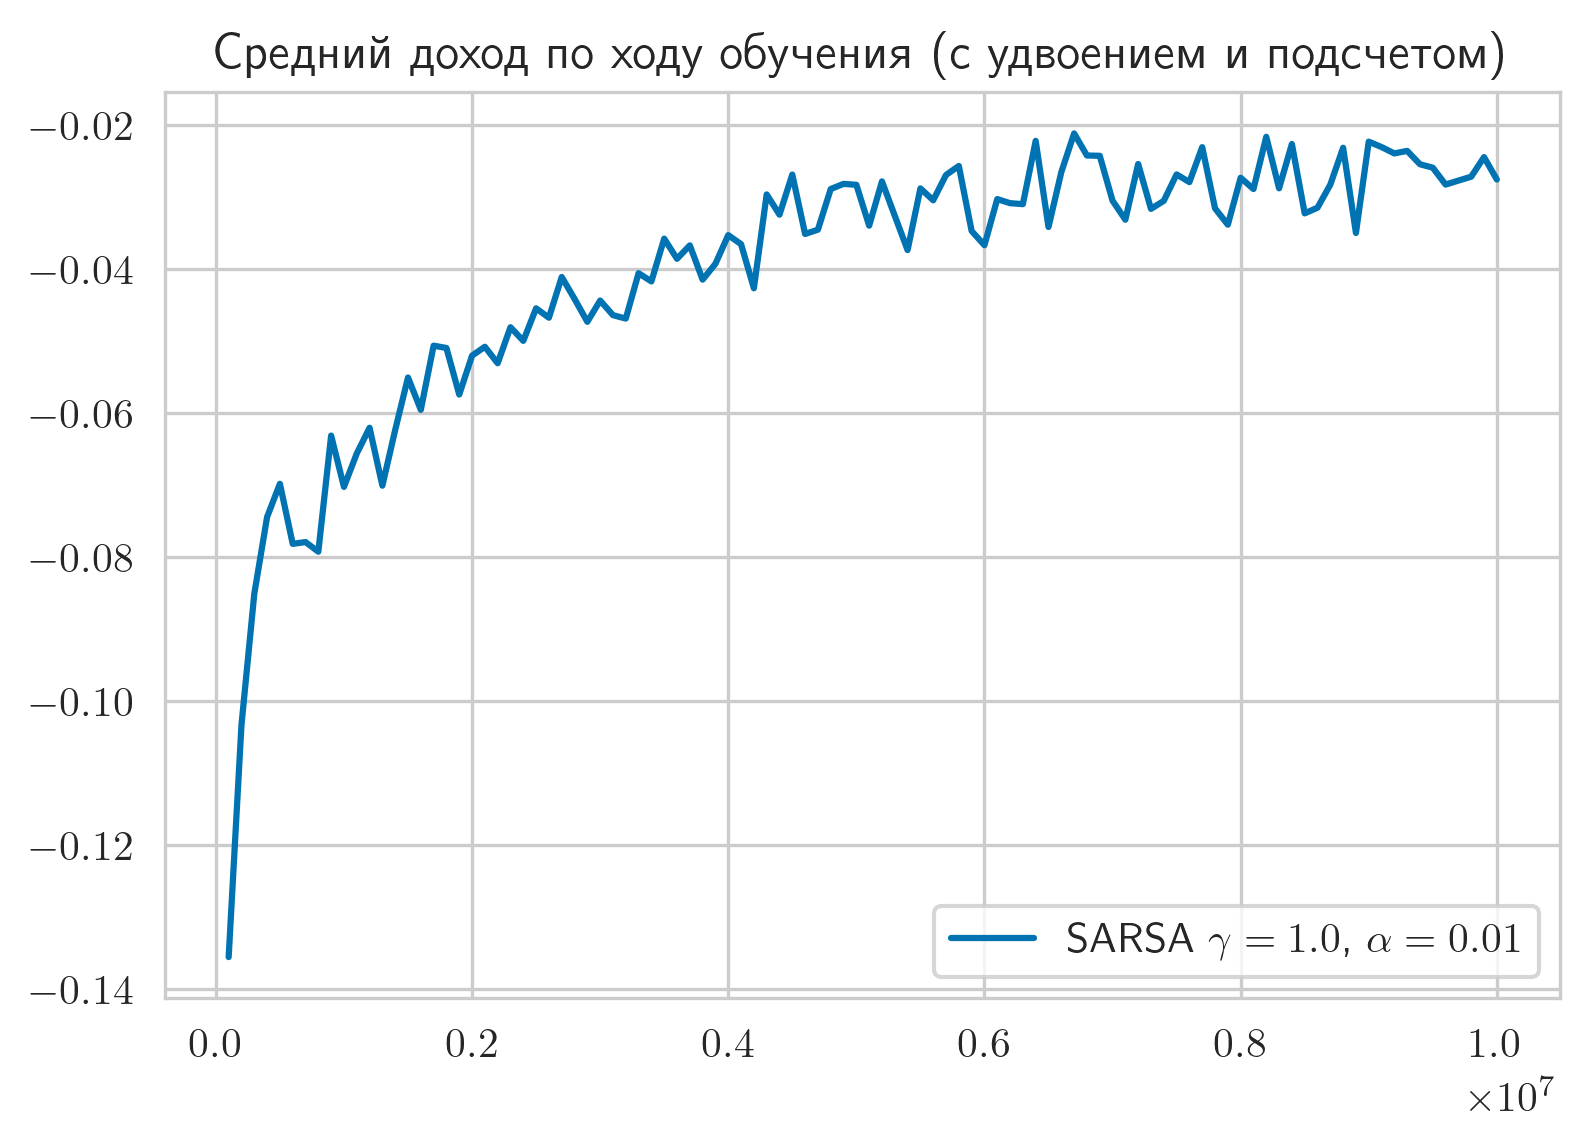

In [262]:
algorithms = [
    {
        'name': 'SARSA',
        'method': sarsa,
        'method_params': { 'gamma': 1.0, 'alpha': 0.01 },
        'eps': lambda: eps_decay(decay=0.01 ** (1 / 10000000)),
        'eps_params': {}
    },
]

plot_learning_curve(
    algorithms,
    env = gym.make('BlackjackDoubleCountingSplitEnv-v0', natural=True, num_decks=1),
    title='Средний доход по ходу обучения (с удвоением и подсчетом)',
    num_experiments=10000000,
    score_every=0.01
)

Посмотрим, как растет качество обучения с **удвоением, подсчетом и сплитом** при использовании алгоритма Q-Learning

2020-11-08 01:34:49.191599 - Learning {'name': 'Q', 'method': <function q_learning at 0x7fe215e997a0>, 'method_params': {'gamma': 1.0, 'alpha': 0.01}, 'eps': <function eps_constant at 0x7fe21d329a70>, 'eps_params': {'epsilon': 0.5}}


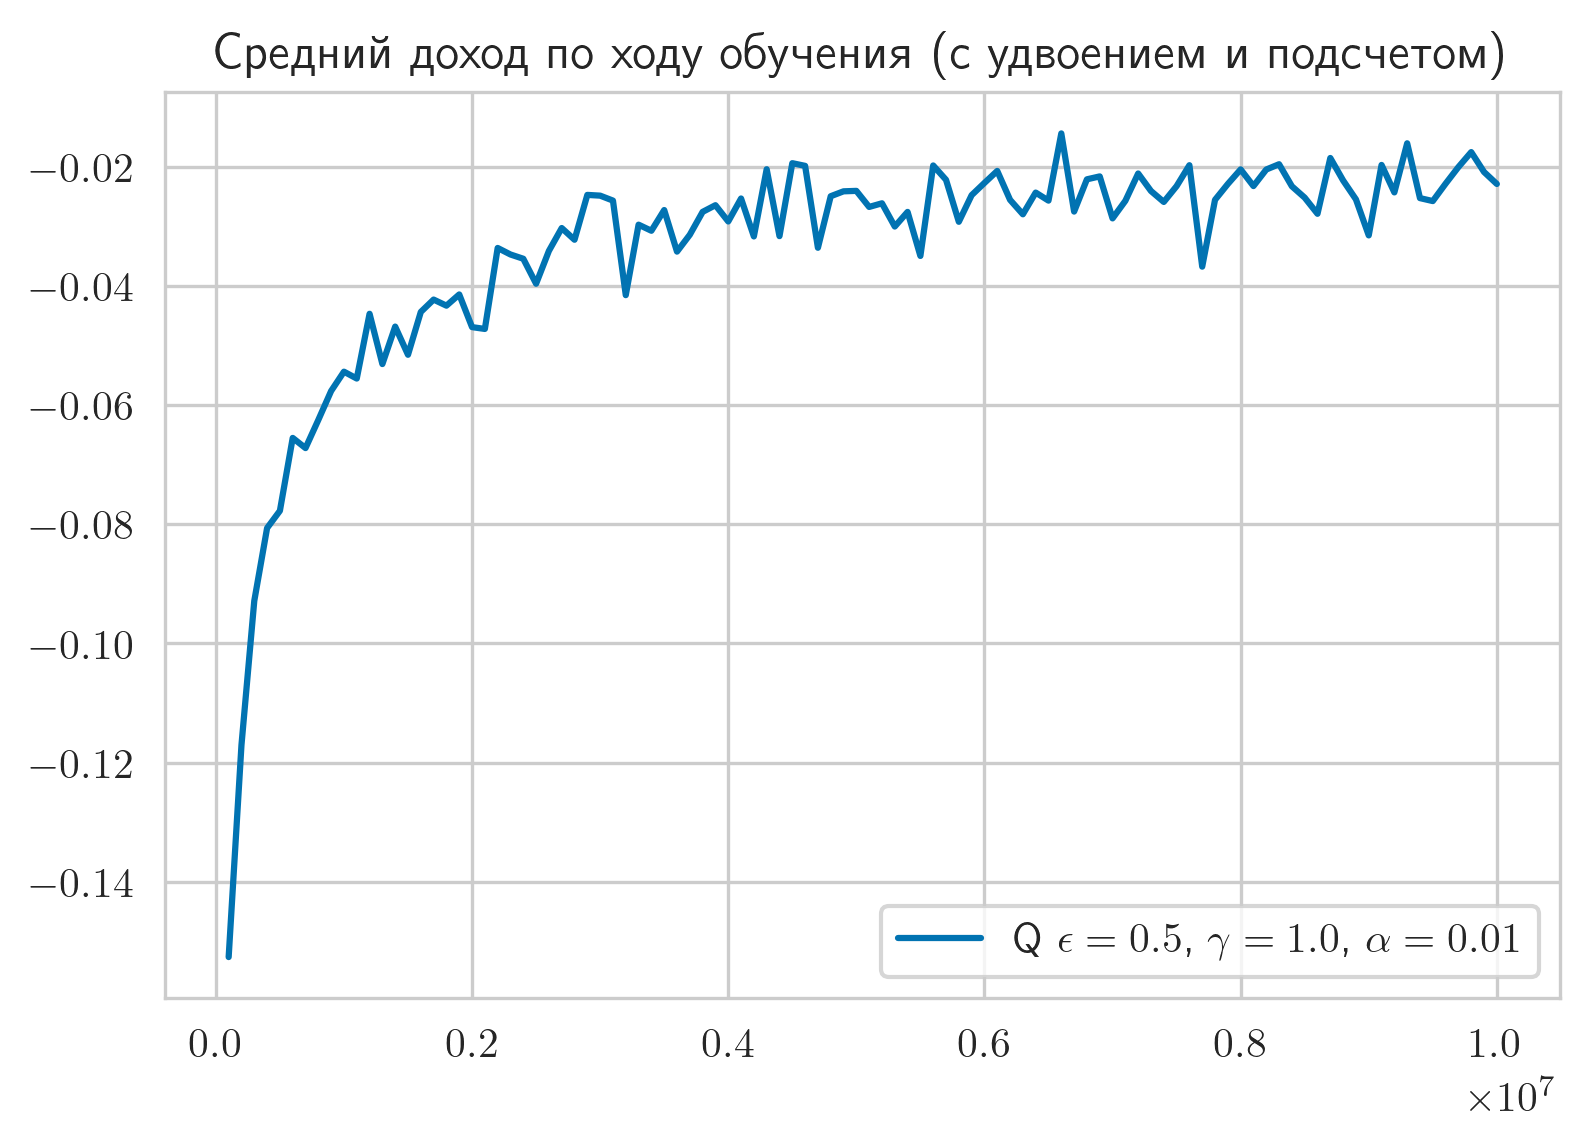

In [263]:
algorithms = [
    {
        'name': 'Q',
        'method': q_learning,
        'method_params': { 'gamma': 1.0, 'alpha': 0.01 },
        'eps': eps_constant,
        'eps_params': { 'epsilon': 0.5 }
    },
]

plot_learning_curve(
    algorithms,
    env = gym.make('BlackjackDoubleCountingSplitEnv-v0', natural=True, num_decks=1),
    title='Средний доход по ходу обучения (с удвоением и подсчетом)',
    num_experiments=10000000,
    score_every=0.01
)

Построим график обучения наилучшего алгоритма на большем числе эпох по блэкджеку **с удвоением, подсчетом карт и сплитом**

2020-11-08 03:08:20.788721 - Learning {'name': 'MC-Off', 'method': <function monte_carlo_control_off_policy at 0x7fe20c0c7b90>, 'method_params': {'gamma': 0.2}, 'eps': <function eps_constant at 0x7fe21d329a70>, 'eps_params': {'epsilon': 0.5}}


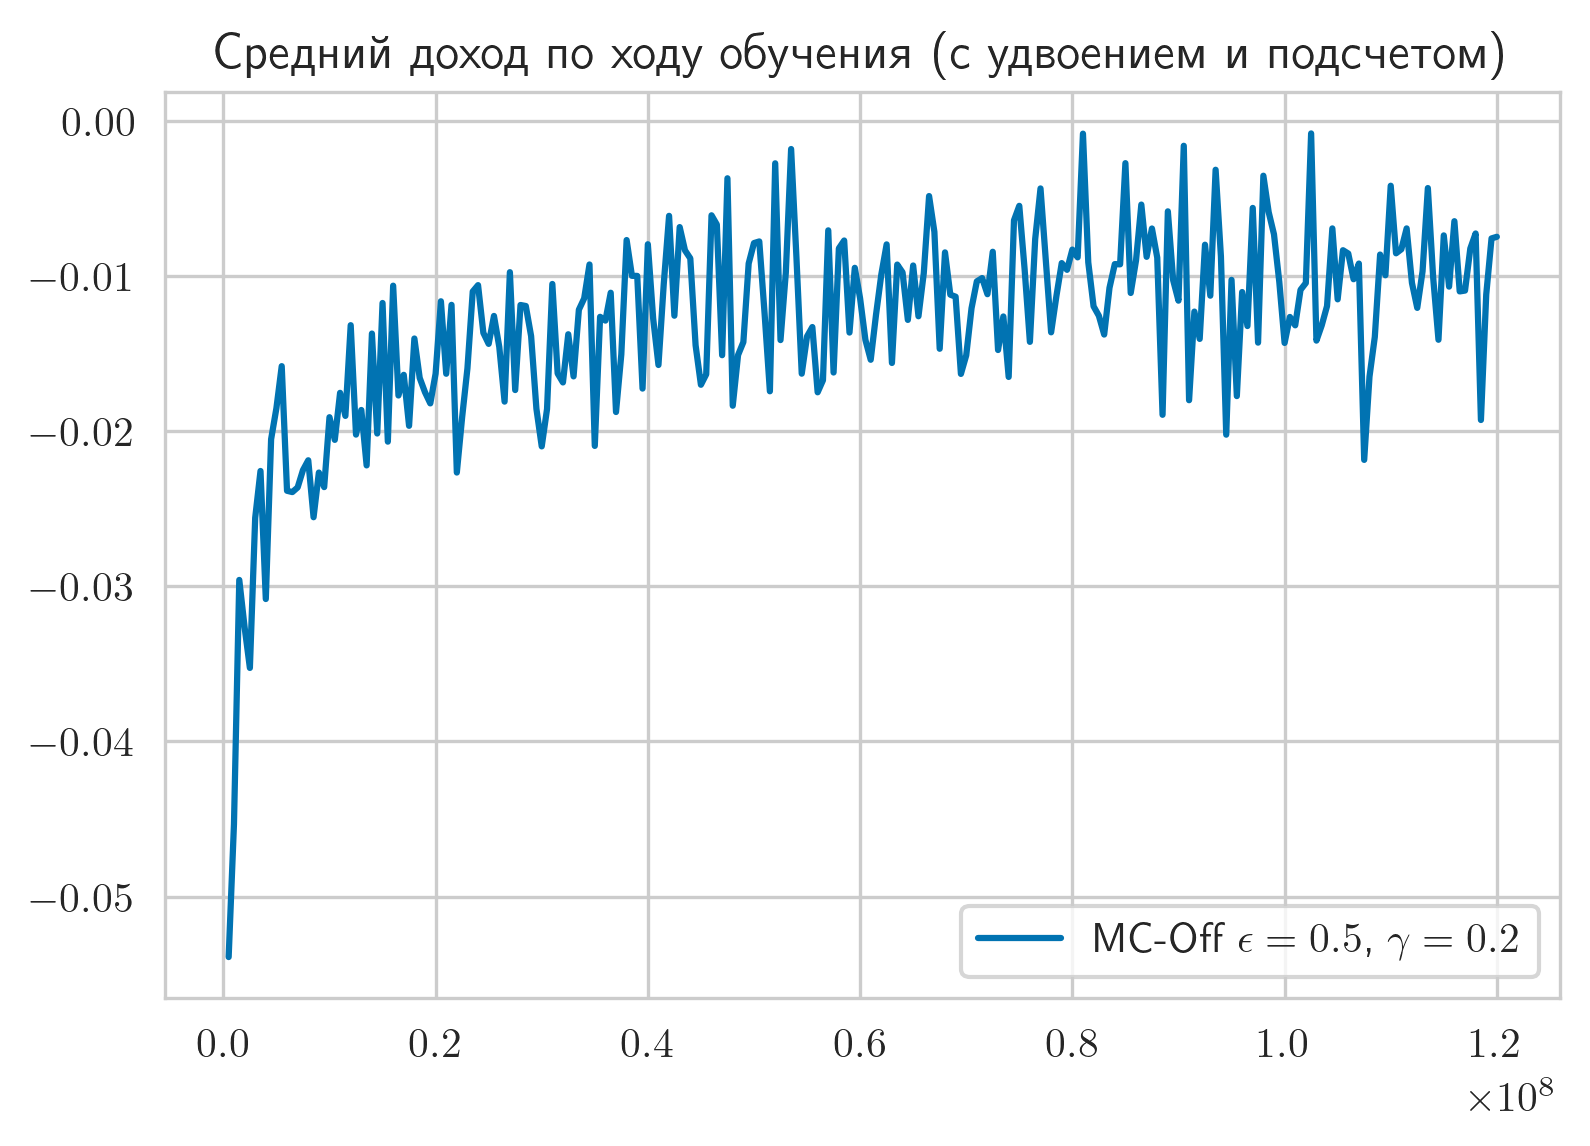

In [268]:
algorithms = [
    {
        'name': 'MC-Off',
        'method': monte_carlo_control_off_policy,
        'method_params': { 'gamma': 0.2 },
        'eps': eps_constant,
        'eps_params': { 'epsilon': 0.5 }
    },
]

plot_learning_curve(
    algorithms,
    env = gym.make('BlackjackDoubleCountingSplitEnv-v0', natural=True, num_decks=1),
    title='Средний доход по ходу обучения (с удвоением и подсчетом)',
    num_experiments=120000000,
    score_every=500000 / 120000000
)

Оценим ожидаемый выигрыш от игры в блэкджек, в котором мы считаем карты, имеем возможность сделать SPLIT и DOUBLE.

In [267]:
%%time
Q_star, scores = monte_carlo_control_off_policy(
    eps_constant(0.5),
    env=gym.make('BlackjackDoubleCountingSplitEnv-v0', natural=True),
    num_experiments=60000000,
    random_state=42,
    gamma=0.2,
    score_func=calculate_reward_by_policy,
    score_every=500000 / 60000000
)

CPU times: user 1h 7min 58s, sys: 1min 2s, total: 1h 9min
Wall time: 1h 7min 59s


In [269]:
calculate_reward_by_policy(
    policy_q(Q_star, 0.0),
    env=gym.make('BlackjackDoubleCountingSplitEnv-v0', natural=True),
    num_experiments=1000000,
#     random_state=42
)

-0.028367

Можно видеть, что качество относительно блэкджека без сплита не растет.

Почему так происходит? На мой взгляд сплит достаточно редкая операция, которой игрок не имеет возможность часто пользоваться. При игре несколькими колодами все становится еще сложнее, подсчеты еще тяжелее, пространство состояний и действий усложняется, тем самым приходится играть еще дольше для накапления статистик. Именно поэтому по последнему графику в целом виден положительный тренд на увеличениче качества, но этот рост очень медленный.

Возможно, стоило лучше поподбирать гиперпараметры алгоритмов, но суммарно все обучение занимало слишком много времени, чтобы столько ждать.

Также я пробовал давать игроку возможность учитывать при подсчете карт "вторую" карту дилера при раздаче (как будто он ее видит). При подобной игре все становится резко хорошо, алгоритмам получается выйти при игре почти в ноль, но этот подход отличается от того, что может произойти в жизни.

### Последняя попытка

Последняя идея, которая у меня появилась - это слегка упростить подсчет карт. При подсчете карт самое важное - знак реального счета, а уже после этого его значение. Попробуем упростить окружение, изменив реальный счет на его знак и посмотрим, что это даст

In [31]:
from gym.envs.registration import register
from blackjack_with_double_counting_split_simplified import BlackjackDoubleCountingSplitSimplifiedEnv

gym.envs.toy_text.blackjack.BlackjackDoubleCountingSplitSimplifiedEnv = BlackjackDoubleCountingSplitSimplifiedEnv

register(
    id='BlackjackDoubleCountingSplitSimplifiedEnv-v0',
    entry_point='gym.envs.toy_text.blackjack:BlackjackDoubleCountingSplitSimplifiedEnv',
)

2020-11-08 12:33:50.043943 - Learning {'name': 'MC-Off', 'method': <function monte_carlo_control_off_policy at 0x7f96a63f3b90>, 'method_params': {'gamma': 0.2}, 'eps': <function eps_constant at 0x7f96a63f33b0>, 'eps_params': {'epsilon': 0.5}}


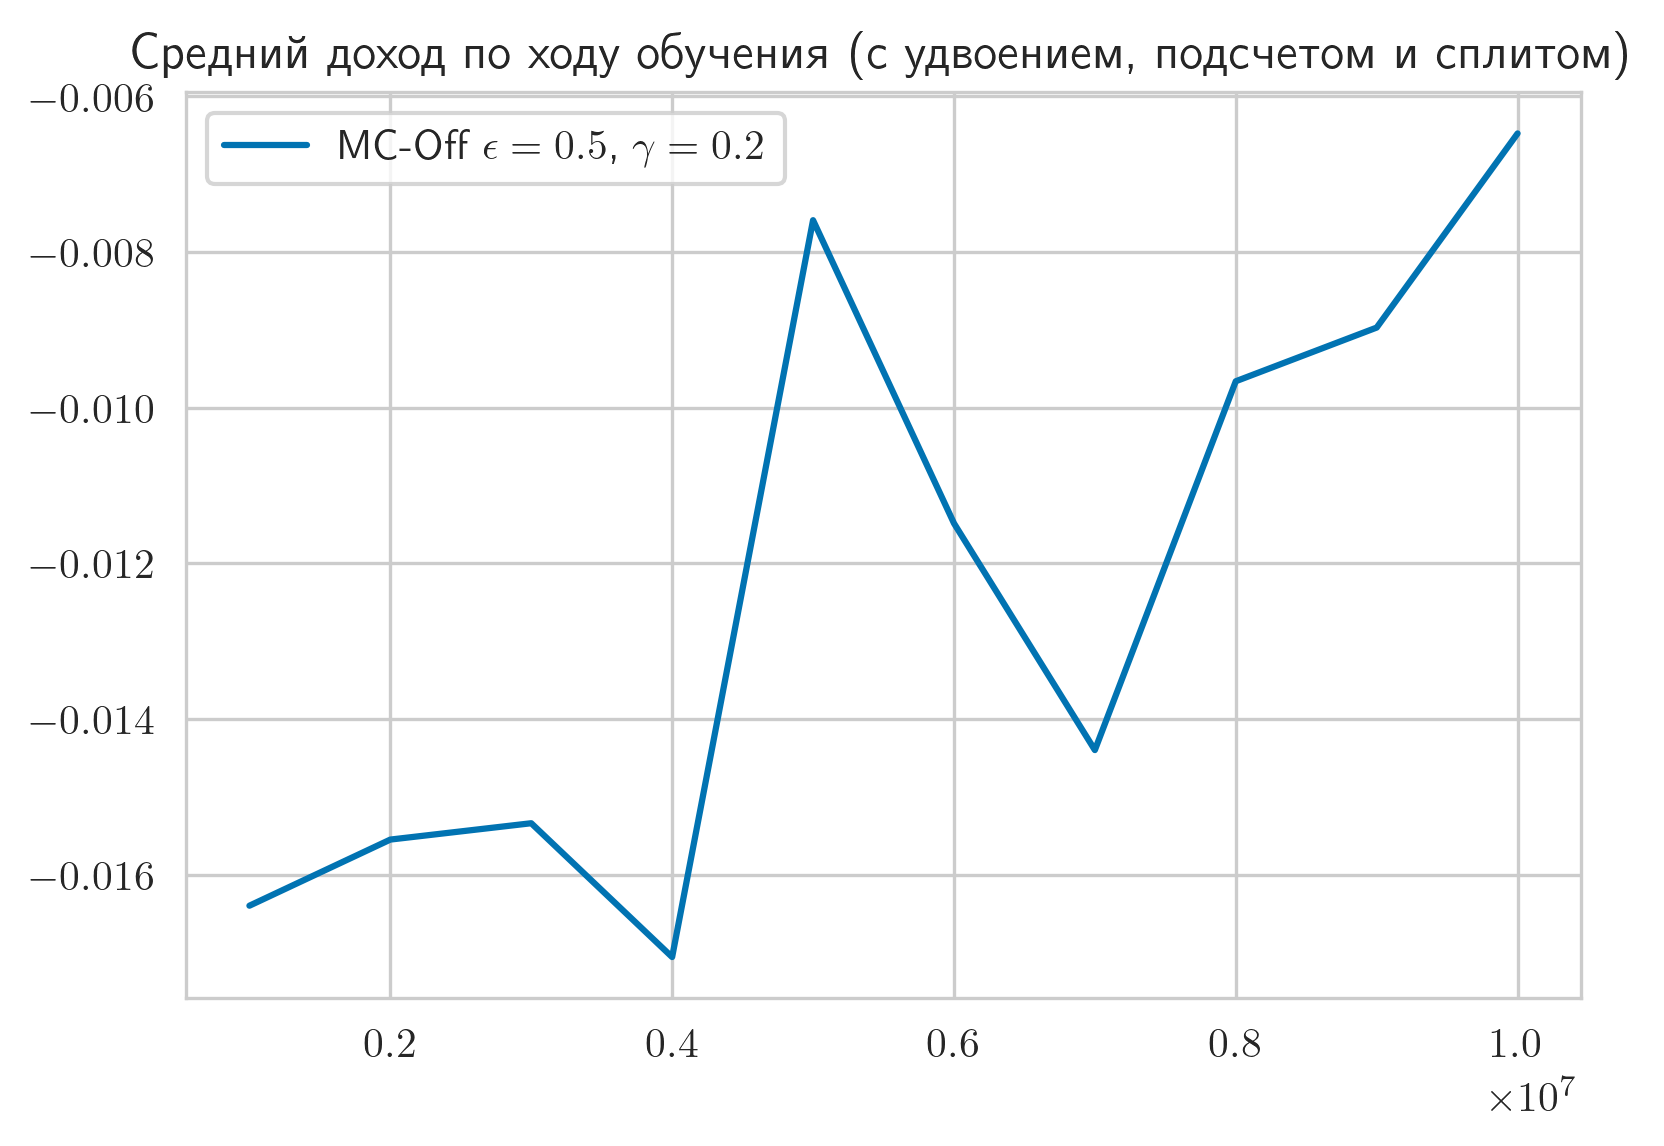

In [27]:
algorithms = [
    {
        'name': 'MC-Off',
        'method': monte_carlo_control_off_policy,
        'method_params': { 'gamma': 0.2 },
        'eps': eps_constant,
        'eps_params': { 'epsilon': 0.5 }
    },
]

plot_learning_curve(
    algorithms,
    env = gym.make('BlackjackDoubleCountingSplitSimplifiedEnv-v0', natural=True, num_decks=1),
    title='Средний доход по ходу обучения (с удвоением, подсчетом и сплитом)',
    num_experiments=10000000,
    score_every=0.1
)

2020-11-08 14:14:39.658165 - Learning {'name': 'MC-Off', 'method': <function monte_carlo_control_off_policy at 0x7f96a63f3b90>, 'method_params': {'gamma': 0.2}, 'eps': <function eps_constant at 0x7f96a63f33b0>, 'eps_params': {'epsilon': 0.5}}


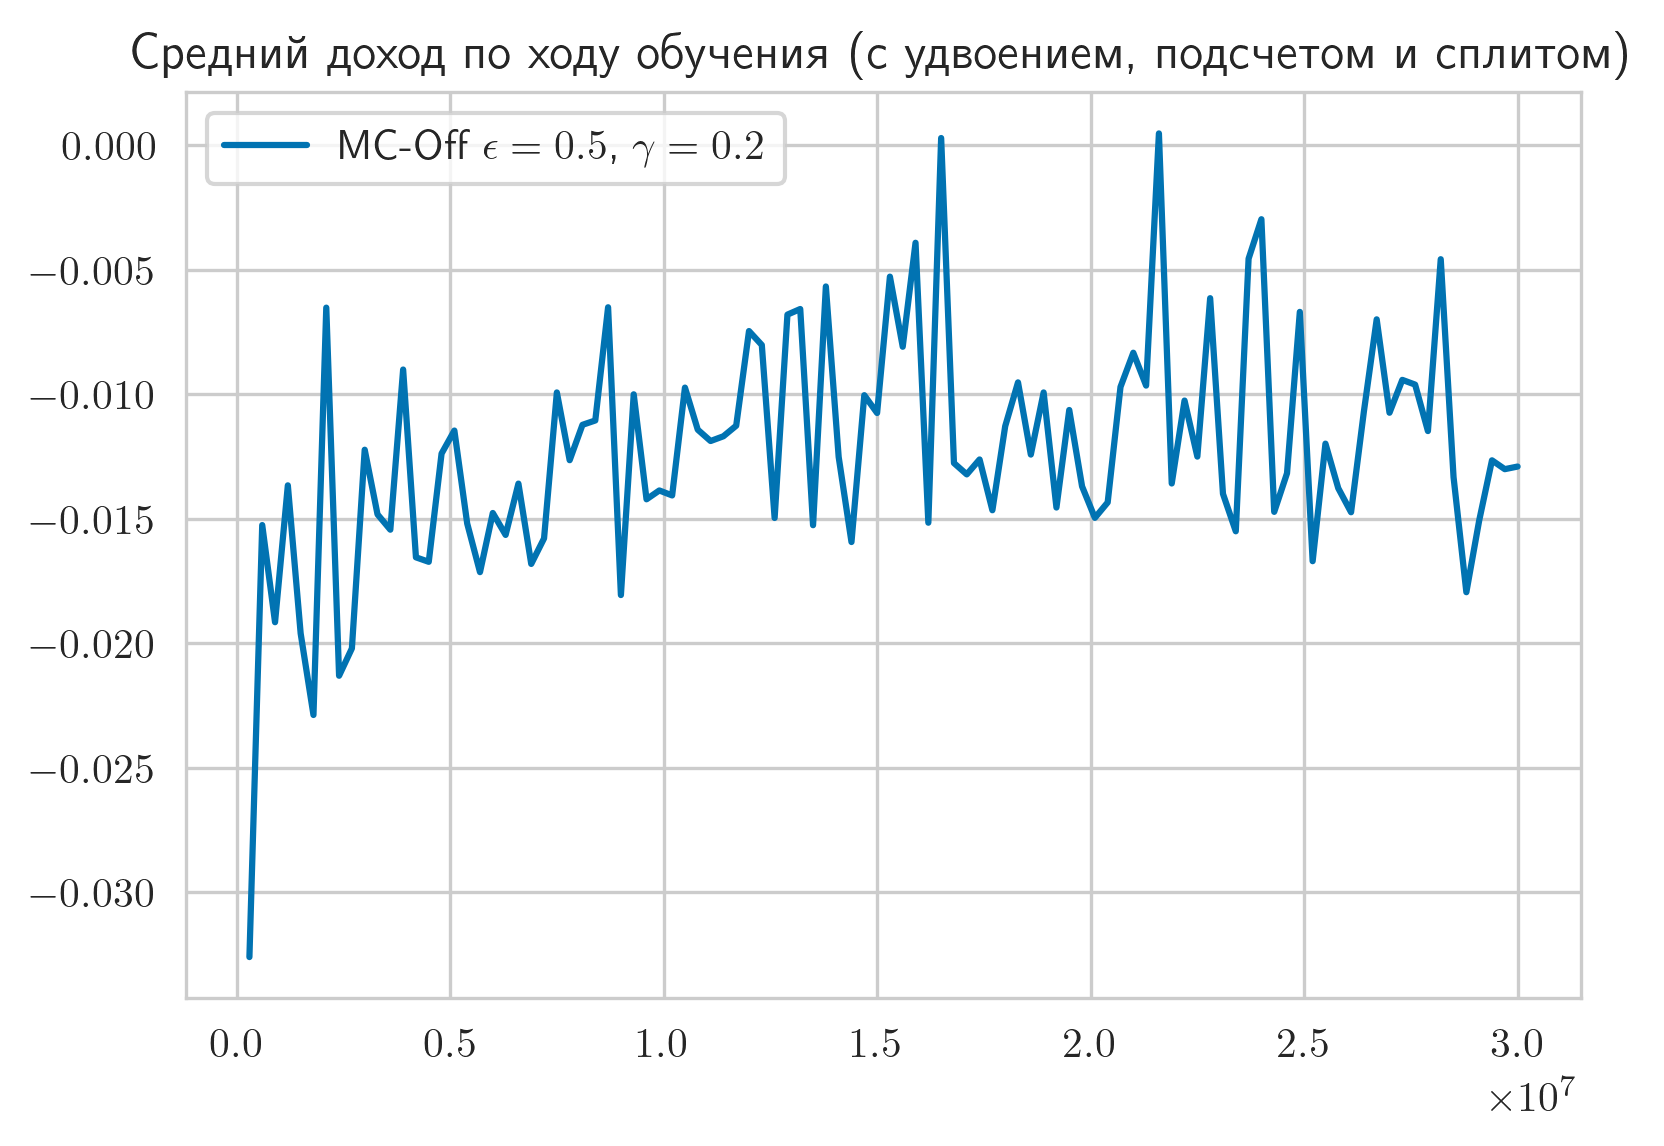

In [39]:
algorithms = [
    {
        'name': 'MC-Off',
        'method': monte_carlo_control_off_policy,
        'method_params': { 'gamma': 0.2 },
        'eps': eps_constant,
        'eps_params': { 'epsilon': 0.5 }
    },
]

plot_learning_curve(
    algorithms,
    env = gym.make('BlackjackDoubleCountingSplitSimplifiedEnv-v0', natural=True, num_decks=1),
    title='Средний доход по ходу обучения (с удвоением, подсчетом и сплитом)',
    num_experiments=30000000,
    score_every=0.01
)

Ого...

Видим, что скор становится сильно лучше от этого подхода. Иногда нам даже получается выйти в плюс (хоть и небольшой)...